In [1]:
import os
import sys
from pathlib import Path
base_dir = str(Path(Path.cwd()).resolve().parent.parent)
print(base_dir)
sys.path.append(base_dir)
import json

B:\data_science_projects\erdos_institute\aware-nlp


In [2]:
import numpy as np
import pandas as pd
embeddings = np.load('all-mpnet-base-v1-chunks-embedded.npz.npy')
df = pd.read_csv('../../data/best_buy/labeling/workers_happy_unhappy_all.csv').sort_values('chunk_id')


In [81]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5667 entries, 686 to 5666
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   label      686 non-null    float64
 1   reason     686 non-null    object 
 2   output     686 non-null    object 
 3   statement  5667 non-null   object 
 4   chunk_id   5667 non-null   int64  
 5   question   5667 non-null   object 
dtypes: float64(1), int64(1), object(4)
memory usage: 439.0+ KB


In [5]:
# import dimensional reductions
from sklearn.decomposition import PCA
from sklearn.manifold import Isomap, LocallyLinearEmbedding, MDS, SpectralEmbedding
from sklearn.metrics.pairwise import cosine_similarity

In [10]:

reductions = {
    'PCA': PCA(n_components=2),
    'Isomap': Isomap(n_components=2),
    'LLE': LocallyLinearEmbedding(n_components=2),
    'Spectral Embedding': SpectralEmbedding(n_components=2),
    'MDS': MDS(n_components=2)
}
reduced_embeddings = {}
for name, reduction in reductions.items():
    print(f'Running {name}...')
    reduced_embeddings[name] = reduction.fit_transform(embeddings)

Running PCA...
Running Isomap...
Running LLE...
Running Spectral Embedding...
Running MDS...


c:\Users\Peter\AppData\Local\Continuum\anaconda3\envs\reddit-rag\Lib\site-packages\sklearn\manifold\_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


In [504]:
# save reduced embeddings
np.savez('all-mpnet-base-v1-chunks-embedded-reduced.npz', **reduced_embeddings)

In [13]:
from langchain_community.document_loaders import DataFrameLoader
import pandas as pd
import json

def format_reddit_entry(entry: dict) -> str:
    title = entry['reddit_title'].strip() if entry['reddit_title'] else ''
    text = entry['reddit_text'].strip() if entry['reddit_text'] else ''
    text = text.replace('\n', ' ')
    if len(title)>0:
        if len(text)>0:
            return title+'; '+text
        return title
    else:
        if len(text)>0:
            return text
    return None
with open('../../data/BestBuyWorkers.json', 'r') as f:
    workers = json.load(f)

sentences = [format_reddit_entry(worker) for worker in workers]
# clean out the None entries
sentences = [sentence for sentence in sentences if sentence]
workers_df = pd.DataFrame(workers)
workers_df['statement'] = sentences
keep_cols = ['statement', 'reddit_id', 'aware_post_type', 'aware_created_ts',
       'reddit_link_id', 'reddit_parent_id', 'reddit_permalink',
       'reddit_subreddit'
]
loader = DataFrameLoader(workers_df[keep_cols], page_content_column='statement')
docs = loader.load()

In [44]:
metadata_df = pd.DataFrame(doc.metadata for doc in retriever.documents)
metadata_df

reddit_id aware_post_type     aware_created_ts reddit_link_id  \
0      12opsul      submission  2023-04-16T17:32:45           None   
1      jgjgy9e         comment  2023-04-16T18:48:06     t3_12opsul   
2      jgjpqmp         comment  2023-04-16T19:55:39     t3_12opsul   
3      12m0ozl      submission  2023-04-14T11:18:57           None   
4      jg9its6         comment  2023-04-14T14:52:47     t3_12m0ozl   
...        ...             ...                  ...            ...   
5662   kttl60a         comment  2024-03-07T16:11:30     t3_1b91wdi   
5663   kttmfik         comment  2024-03-07T16:18:42     t3_1b91wdi   
5664   kttj3mt         comment  2024-03-07T15:59:47     t3_1b91wdi   
5665   ktt37u3         comment  2024-03-07T14:20:49     t3_1b91wdi   
5666   kttck0f         comment  2024-03-07T15:22:55     t3_1b91wdi   

     reddit_parent_id                                   reddit_permalink  \
0                None  /r/BestBuyWorkers/comments/12opsul/research_st...   
1          t3_12opsul  /r/BestBuyWorkers/comments/12opsul/research_st...   
2          t3_12opsul  /r/BestBuyWorkers/comments/12opsul/research_st...   
3                None  /r/BestBuyWorkers/comments/12m0ozl/sr_role_eli...   
4          t3_12m0ozl  /r/BestBuyWorkers/comments/12m0ozl/sr_role_eli...   
...               ...                                                ...   
5662       t3_1b91wdi  /r/BestBuyWorkers/comments/1b91wdi/sti_bonus/k...   
5663       t3_1b91wdi  /r/BestBuyWorkers/comments/1b91wdi/sti_bonus/k...   
5664       t3_1b91wdi  /r/BestBuyWorkers/comments/1b91wdi/sti_bonus/k...   
5665       t3_1b91wdi  /r/BestBuyWorkers/comments/1b91wdi/sti_bonus/k...   
5666       t1_ktt455y  /r/BestBuyWorkers/comments/1b91wdi/sti_bonus/k...   

     reddit_subreddit  
0      BestBuyWorkers  
1      BestBuyWorkers  
2      BestBuyWorkers  
3      BestBuyWorkers  
4      BestBuyWorkers  
...               ...  
5662   BestBuyWorkers  
5663   BestBuyWorkers  
5664   BestBuyWorkers  
5665   BestBuyWorkers  
5666   BestBuyWorkers  

[5667 rows x 7 columns]

In [80]:
df_all = pd.concat((df, metadata_df), axis=1)
df_all.to_csv('../../data/best_buy/labeling/workers_happy_unhappy_all_with_metadata.csv', index=False)

In [14]:
from src.retriever import CustomRetriever
retriever = CustomRetriever(docs, 'all-mpnet-base-v1', 'cosine-similarity')
retriever._initialize_embedding_model()
retriever._initialize_splitter()
retriever.split_documents()
retriever.embeddings = list(embeddings)



c:\Users\Peter\AppData\Local\Continuum\anaconda3\envs\reddit-rag\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [15]:
keywords = [
    'happy',
    'unhappy',
    'layoffs',
    'satisfied',
    'unsatisfied',
    'reduction in hours',
    'quit',
    'fired',
    "management", 
    "leadership",
    "Are employees happy with the management?",
    "Are employess unhappy with the management?",
    "Are employees unsatisfied with management?",
    "Are employees satisfied with management?",
    "Are employees happy with the shcheduling of their hours?",
    "Are employees unhappy with the scheduling of their hours?",
]
# 
keyword_embeddings = [retriever.encoder.encode(keyword) for keyword in keywords]

In [16]:
# For each keyword, calculate the cosine similarity between the keyword and each worker statement
keyword_similarities = []
for keyword_embedding in keyword_embeddings:
    keyword_similarities.append([cosine_similarity([keyword_embedding], [worker_embedding])[0][0] for worker_embedding in embeddings])

In [52]:
reduction_name = 'Isomap'
selected_keywords = [
    'happy',
    'unhappy',
    'satisfied',
    'unsatisfied',
    "management", 
    "leadership",
    "Are employees happy with the management?",
    "Are employess unhappy with the management?",
    "Are employees unsatisfied with management?",
    "Are employees satisfied with management?",
]
selected_keyword_indices = [keywords.index(keyword) for keyword in selected_keywords]
selected_keyword_similarities = np.array(keyword_similarities)[selected_keyword_indices]
selected_keyword_embeddings = np.array(keyword_embeddings)[selected_keyword_indices]

# Plot the reduced embeddings as different figures in the same plot
reducer = reductions[reduction_name]
reduced_vectors = reduced_embeddings[reduction_name]


In [56]:
np.max(np.abs(selected_keyword_similarities))

0.67763203

In [59]:
from src.util.string_formatting import wrap_text

C:\Users\peter\AppData\Local\Temp\ipykernel_1372\1182201910.py:42: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


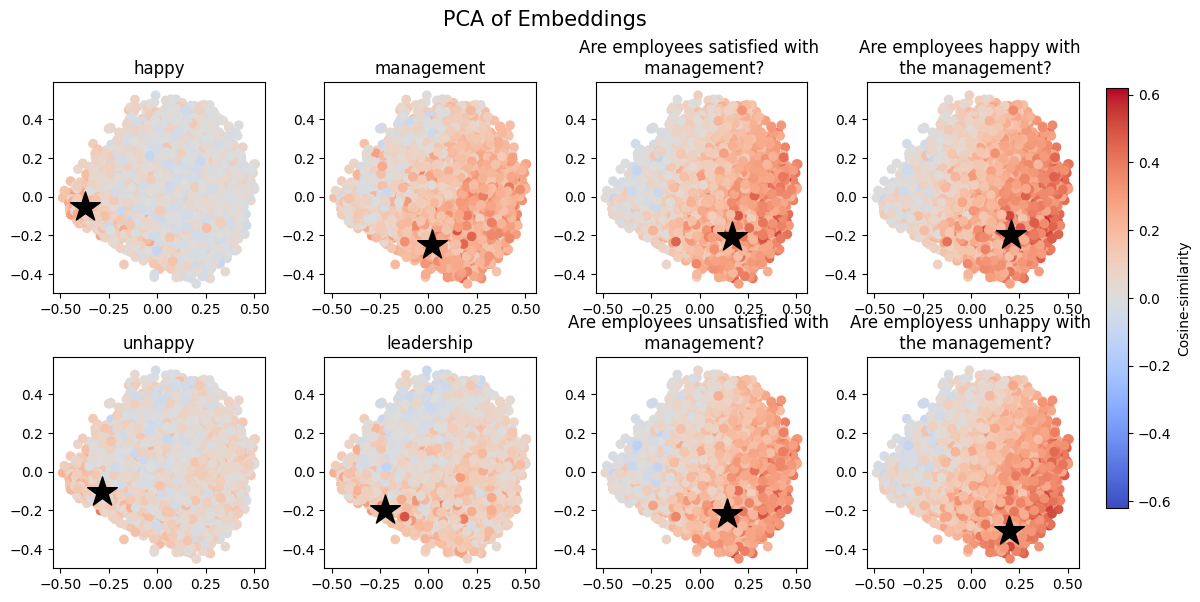

In [76]:
reduction_name = 'PCA'
selected_keywords = [
    'happy',
    "management",
    "Are employees satisfied with management?",
    "Are employees happy with the management?",
    'unhappy', 
    "leadership",
    "Are employees unsatisfied with management?",
    "Are employess unhappy with the management?",
]
selected_keyword_indices = [keywords.index(keyword) for keyword in selected_keywords]
selected_keyword_similarities = np.array(keyword_similarities)[selected_keyword_indices]
selected_keyword_embeddings = np.array(keyword_embeddings)[selected_keyword_indices]

# Plot the reduced embeddings as different figures in the same plot
reducer = reductions[reduction_name]
reduced_vectors = reduced_embeddings[reduction_name]

max_abs_dist = np.max(np.abs(selected_keyword_similarities)) * 0.9
min_dist = -max_abs_dist - 0.01
max_dist = max_abs_dist + 0.01

# Create a figure with subplots
fig = plt.figure(figsize=(11, 6))
for ind, (keyword, keyword_embedding, keyword_similarities_slice) in enumerate(zip(selected_keywords, selected_keyword_embeddings, selected_keyword_similarities)):
    dist = keyword_similarities_slice
    
    reduced_vectors = reduced_embeddings[reduction_name]
    reduced_u = reducer.transform([keyword_embedding])[0]

    ax = fig.add_subplot(2,4, ind + 1)
    im = ax.scatter(reduced_vectors[:, 0], reduced_vectors[:, 1], c=keyword_similarities_slice, cmap='coolwarm', vmin=min_dist, vmax=max_dist)
    ax.scatter(reduced_u[0], reduced_u[1], marker='*', color='k', s=500)
    ax.set_title(f'{wrap_text(keyword, n_words = 4)}')
    ax.axis('square')
fig.suptitle(f'{reduction_name} of Embeddings', fontsize=15)
# Add colorbar to the figure with title "Cosine-similarity" on the right
cax = fig.add_axes([1.01, 0.15, 0.02, 0.7])  # Adjust the position of the colorbar
fig.colorbar(im, cax=cax, label='Cosine-similarity')
# Show the plots
plt.tight_layout()
plt.show()

C:\Users\peter\AppData\Local\Temp\ipykernel_1372\4271719957.py:43: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


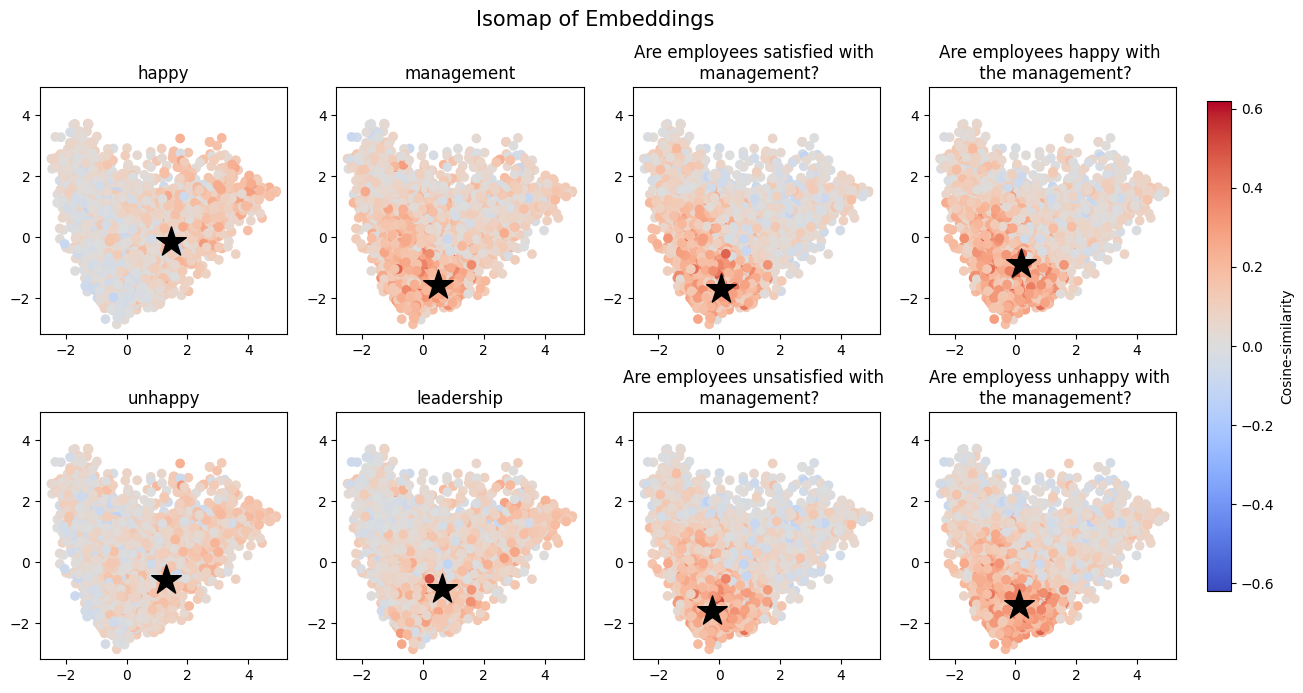

In [79]:
reduction_name = 'Isomap'
selected_keywords = [
    'happy',
    "management",
    "Are employees satisfied with management?",
    "Are employees happy with the management?",
    'unhappy', 
    "leadership",
    "Are employees unsatisfied with management?",
    "Are employess unhappy with the management?",
]
selected_keyword_indices = [keywords.index(keyword) for keyword in selected_keywords]
selected_keyword_similarities = np.array(keyword_similarities)[selected_keyword_indices]
selected_keyword_embeddings = np.array(keyword_embeddings)[selected_keyword_indices]

# Plot the reduced embeddings as different figures in the same plot
reducer = reductions[reduction_name]
reduced_vectors = reduced_embeddings[reduction_name]

max_abs_dist = np.max(np.abs(selected_keyword_similarities)) * 0.9
min_dist = -max_abs_dist - 0.01
max_dist = max_abs_dist + 0.01

n_across = np.ceil(len(selected_keywords)/2).astype(int)
# Create a figure with subplots
fig = plt.figure(figsize=(n_across * 3, 7))
for ind, (keyword, keyword_embedding, keyword_similarities_slice) in enumerate(zip(selected_keywords, selected_keyword_embeddings, selected_keyword_similarities)):
    dist = keyword_similarities_slice
    
    reduced_vectors = reduced_embeddings[reduction_name]
    reduced_u = reducer.transform([keyword_embedding])[0]

    ax = fig.add_subplot(2,4, ind + 1)
    im = ax.scatter(reduced_vectors[:, 0], reduced_vectors[:, 1], c=keyword_similarities_slice, cmap='coolwarm', vmin=min_dist, vmax=max_dist)
    ax.scatter(reduced_u[0], reduced_u[1], marker='*', color='k', s=500)
    ax.set_title(f'{wrap_text(keyword, n_words = 4)}')
    ax.axis('square')
fig.suptitle(f'{reduction_name} of Embeddings', fontsize=15)
# Add colorbar to the figure with title "Cosine-similarity" on the right
cax = fig.add_axes([1.01, 0.15, 0.02, 0.7])  # Adjust the position of the colorbar
fig.colorbar(im, cax=cax, label='Cosine-similarity')
# Show the plots
plt.tight_layout()
plt.show()

## Individual Plots of the keywords in the reduced space

C:\Users\peter\AppData\Local\Temp\ipykernel_1372\3444741007.py:41: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


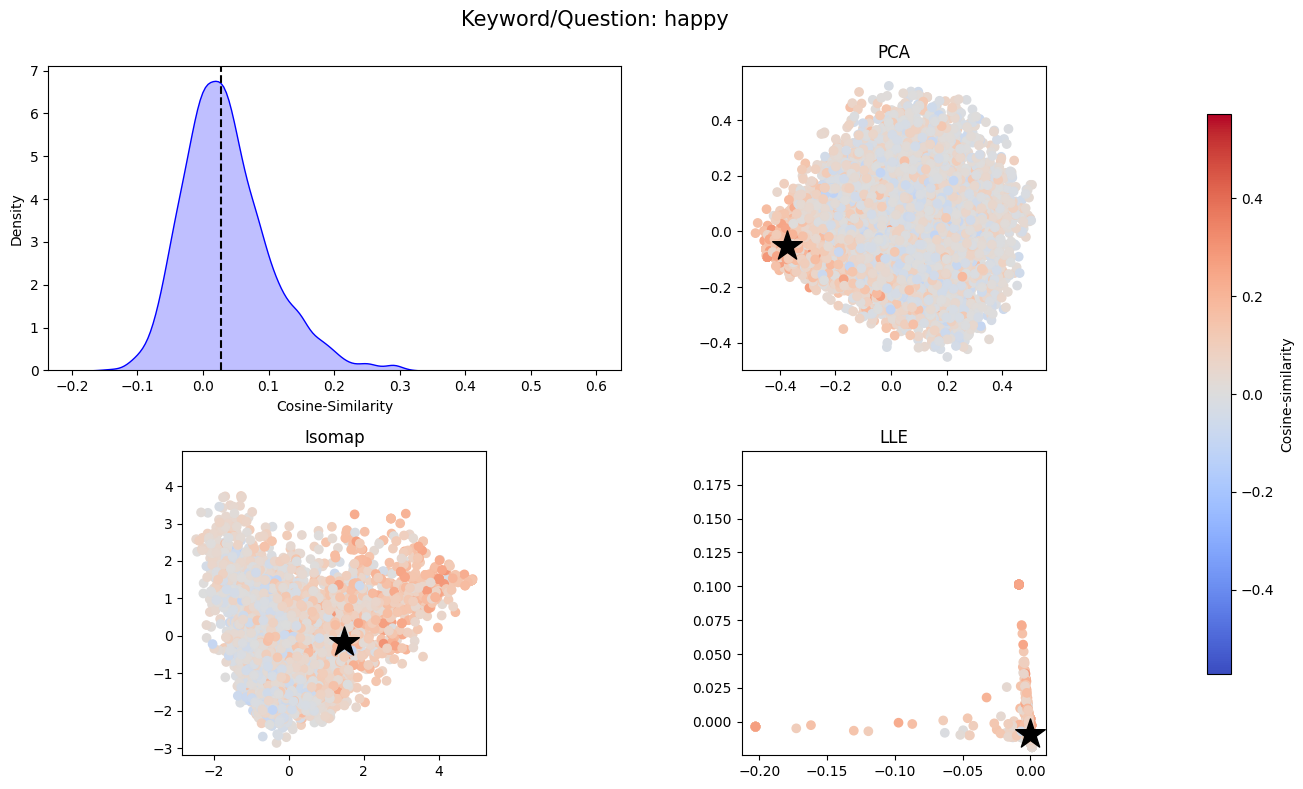

C:\Users\peter\AppData\Local\Temp\ipykernel_1372\3444741007.py:41: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


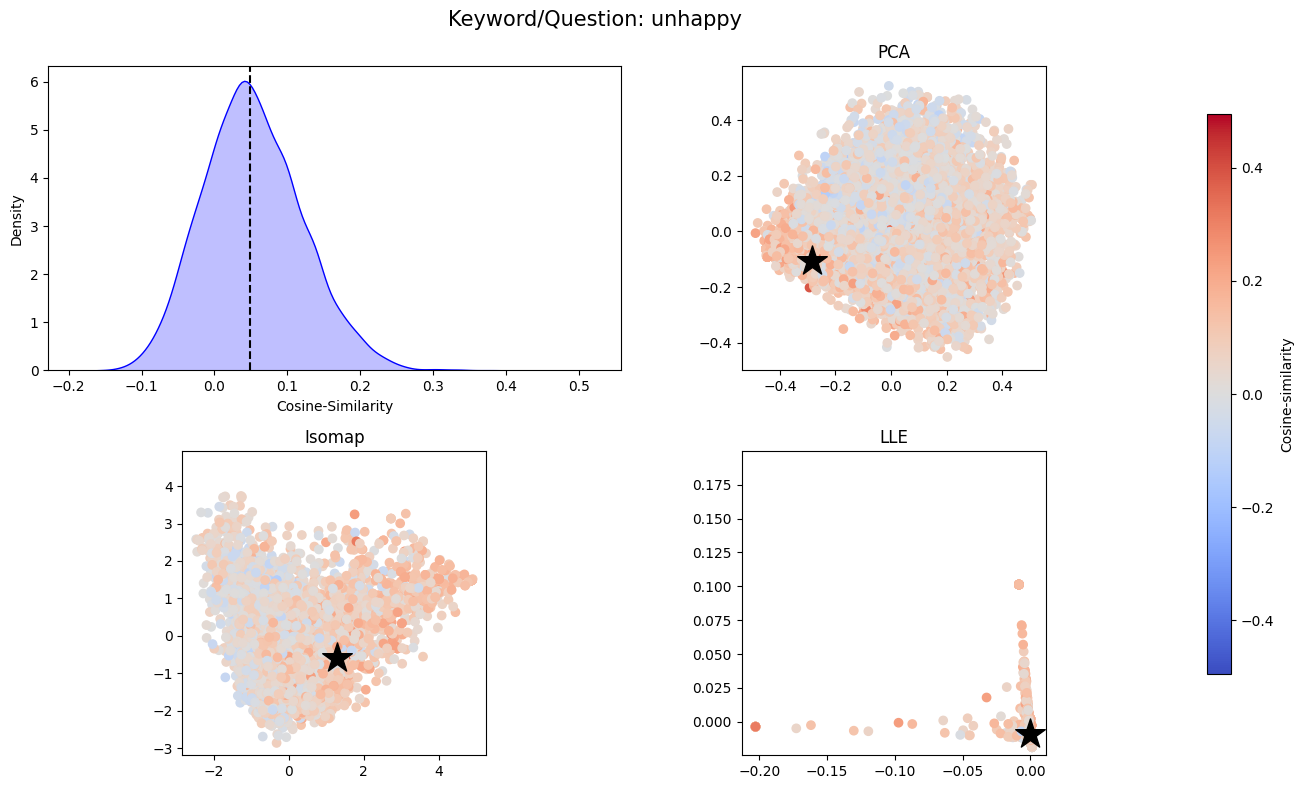

C:\Users\peter\AppData\Local\Temp\ipykernel_1372\3444741007.py:41: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


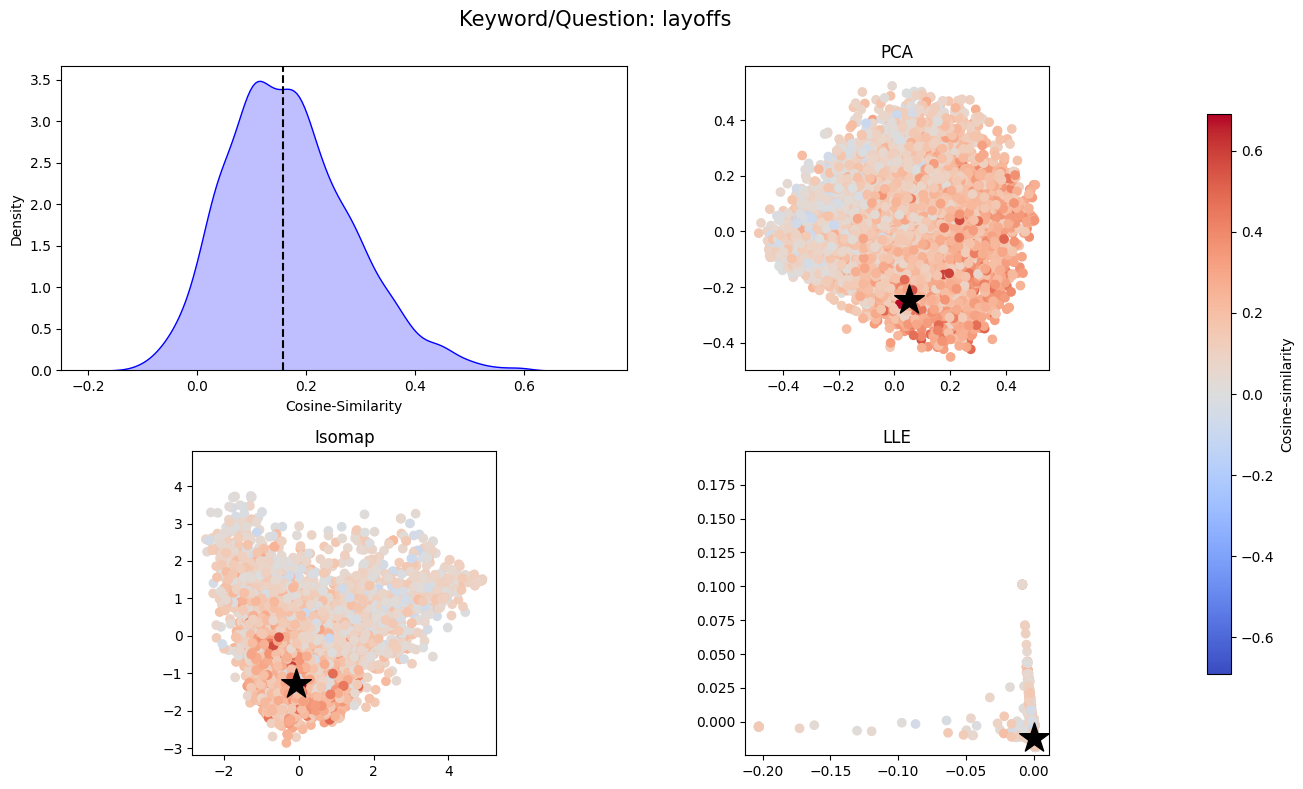

C:\Users\peter\AppData\Local\Temp\ipykernel_1372\3444741007.py:41: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


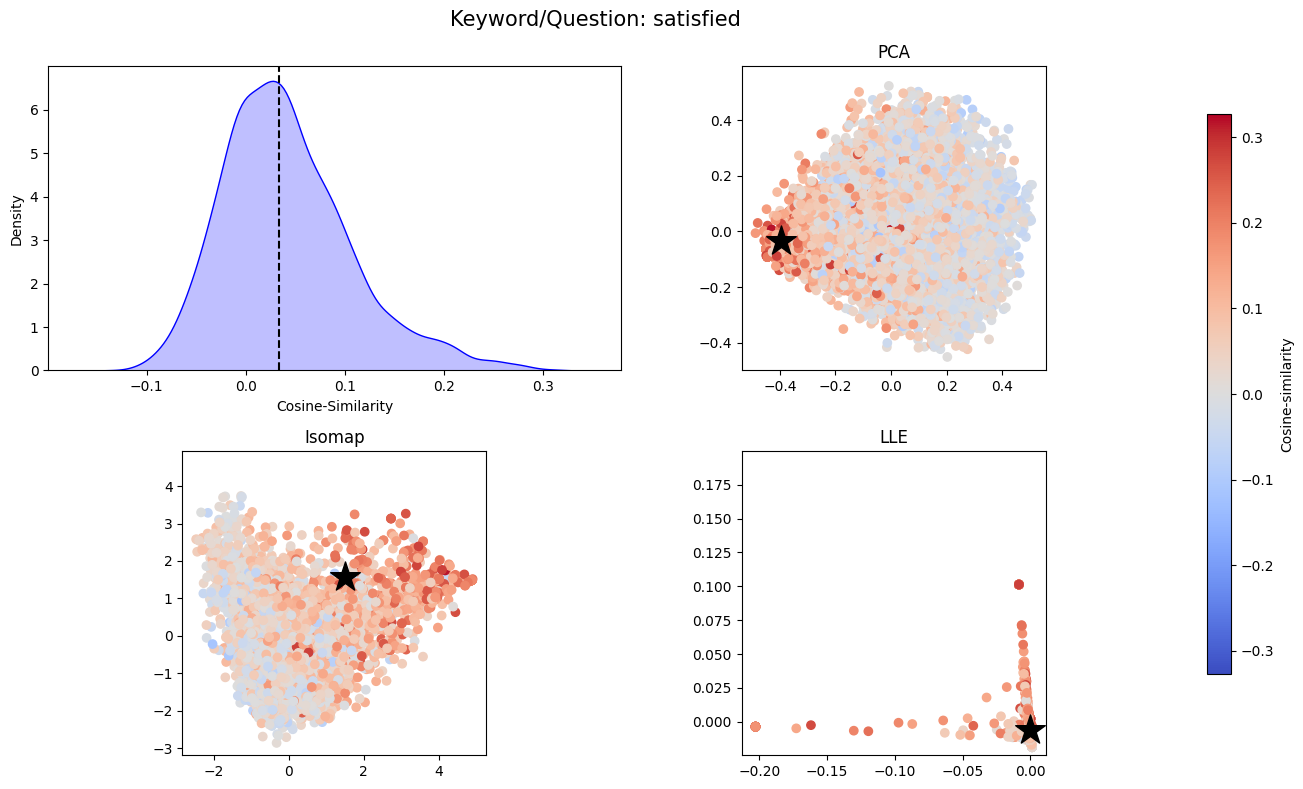

C:\Users\peter\AppData\Local\Temp\ipykernel_1372\3444741007.py:41: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


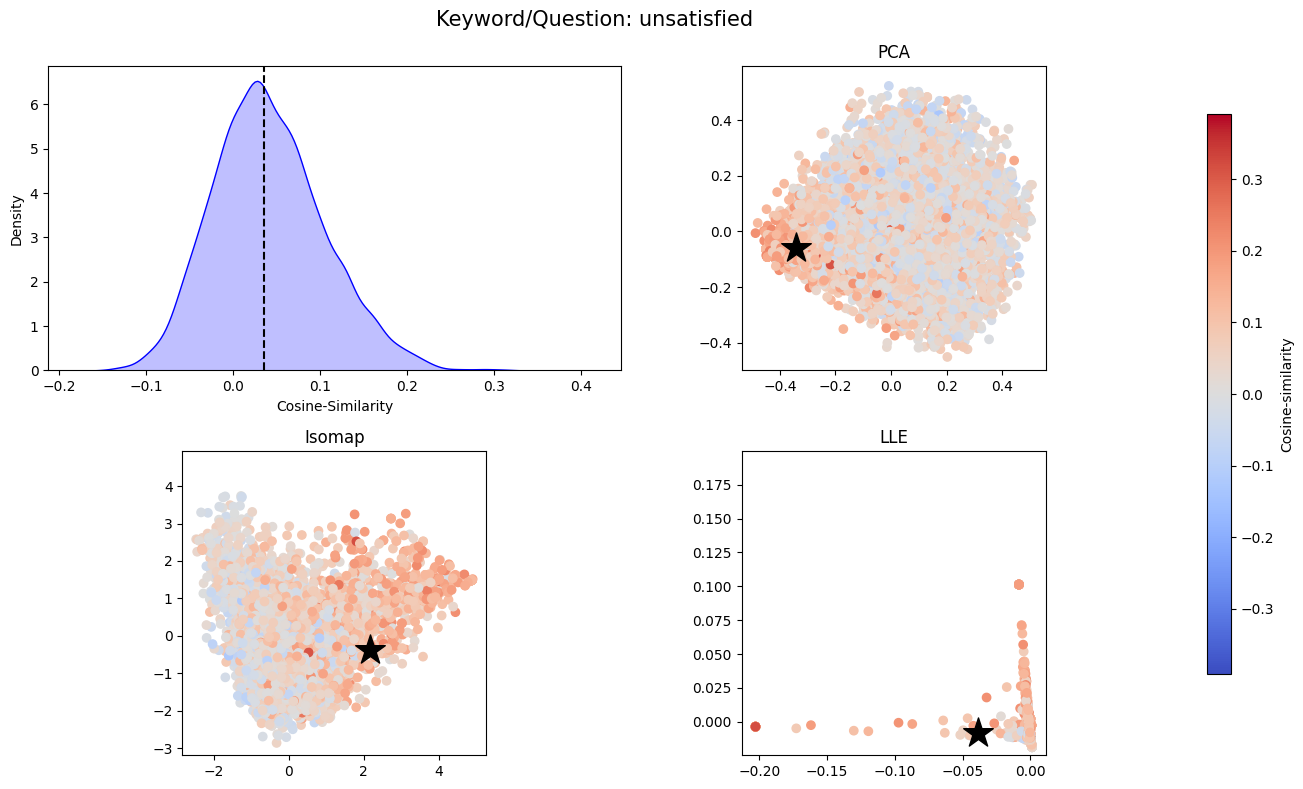

C:\Users\peter\AppData\Local\Temp\ipykernel_1372\3444741007.py:41: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


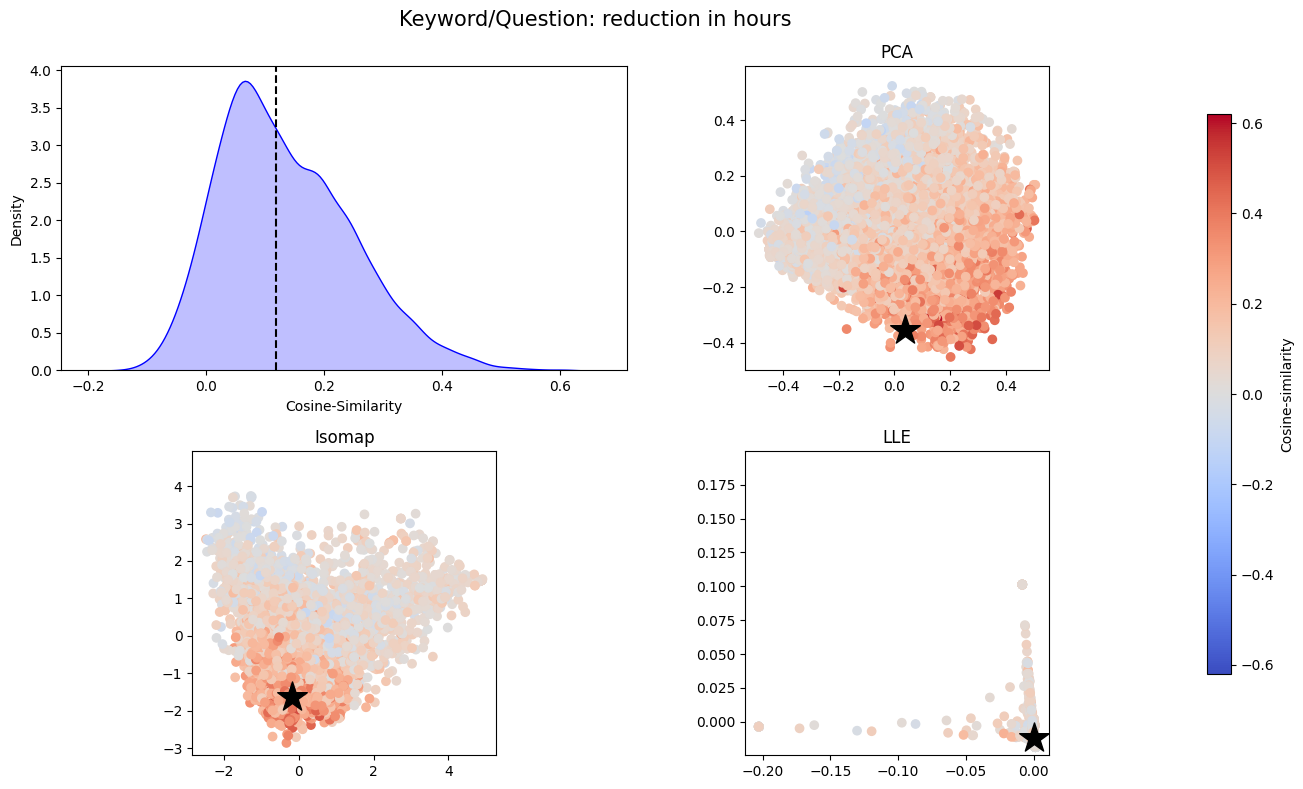

C:\Users\peter\AppData\Local\Temp\ipykernel_1372\3444741007.py:41: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


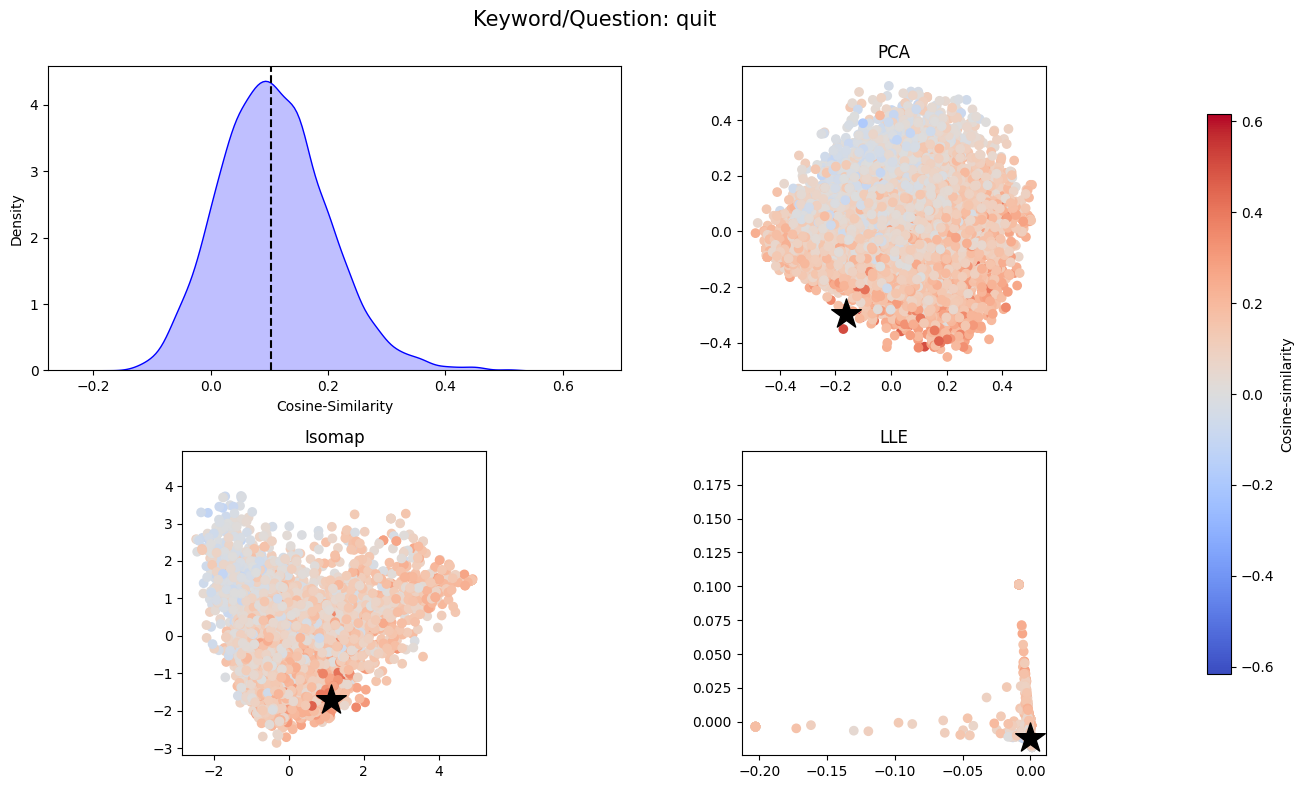

C:\Users\peter\AppData\Local\Temp\ipykernel_1372\3444741007.py:41: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


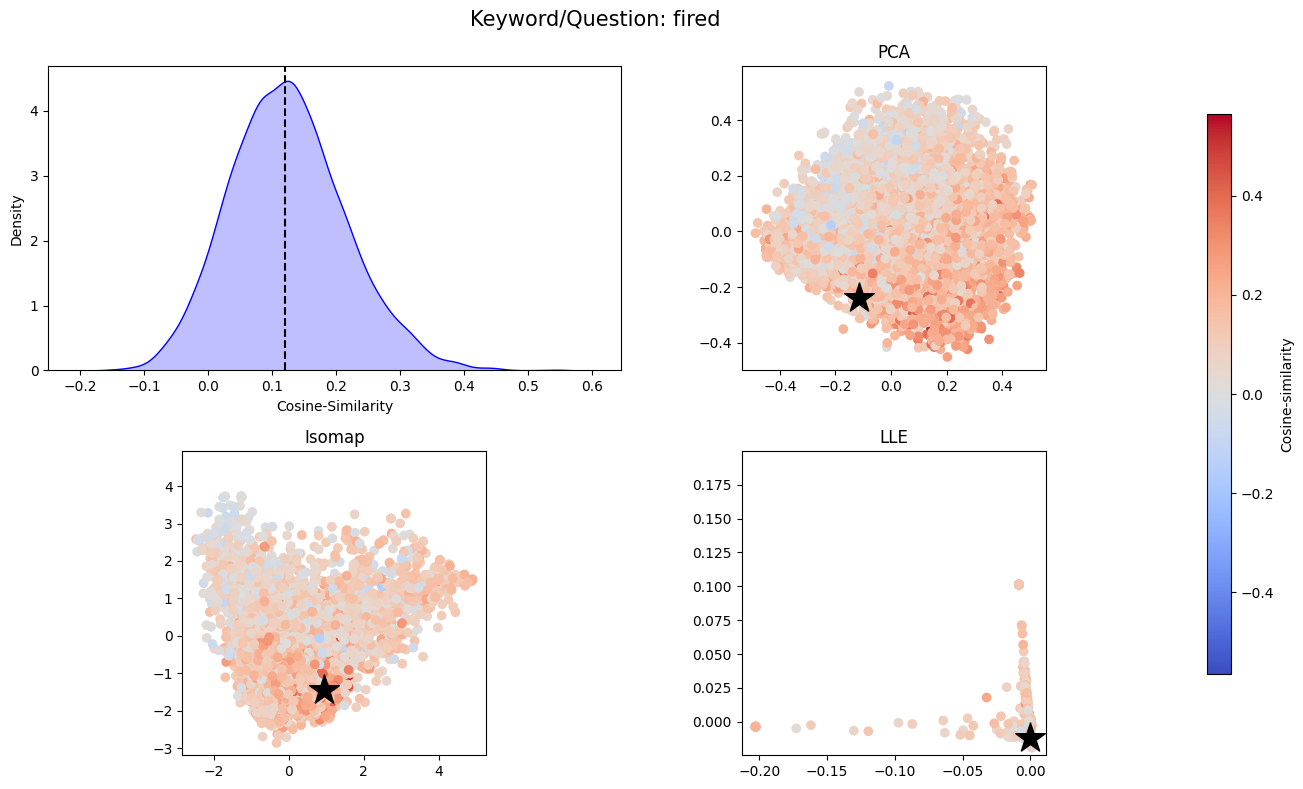

C:\Users\peter\AppData\Local\Temp\ipykernel_1372\3444741007.py:41: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


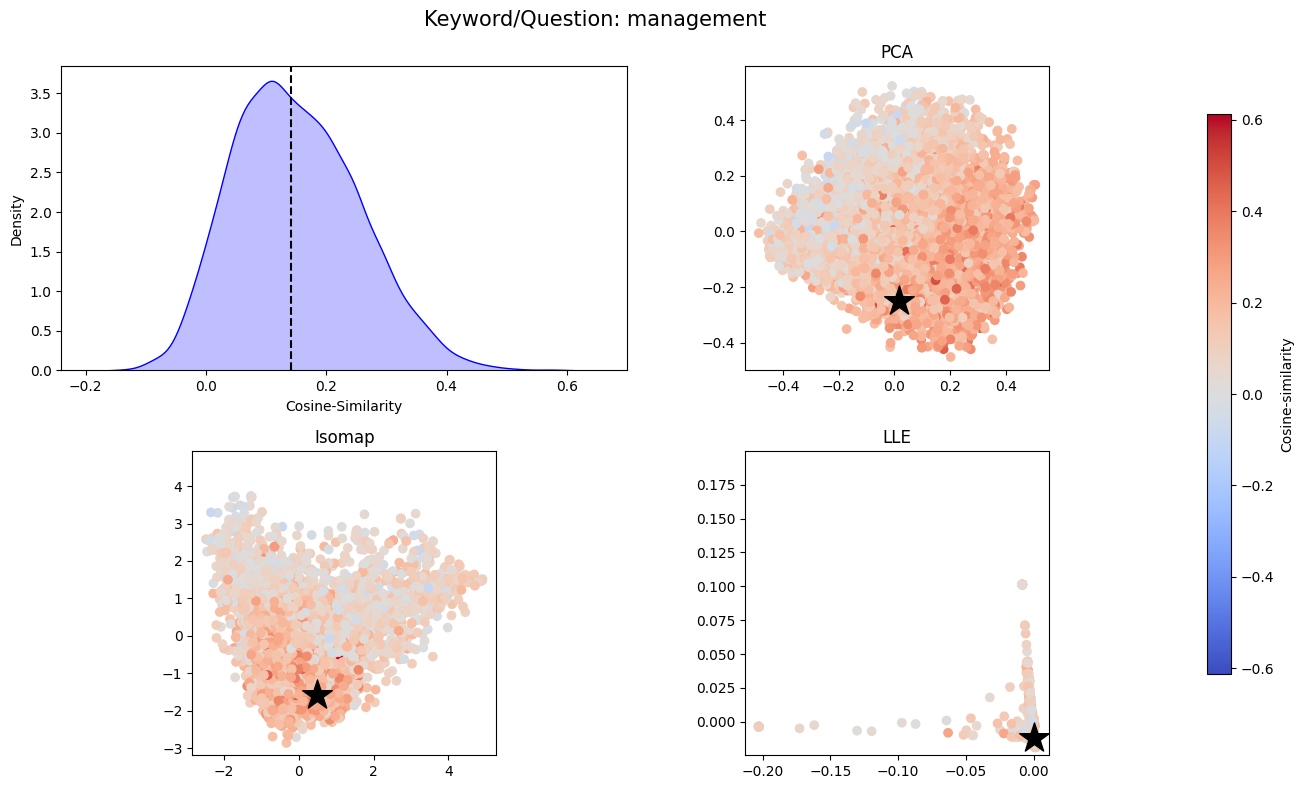

C:\Users\peter\AppData\Local\Temp\ipykernel_1372\3444741007.py:41: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


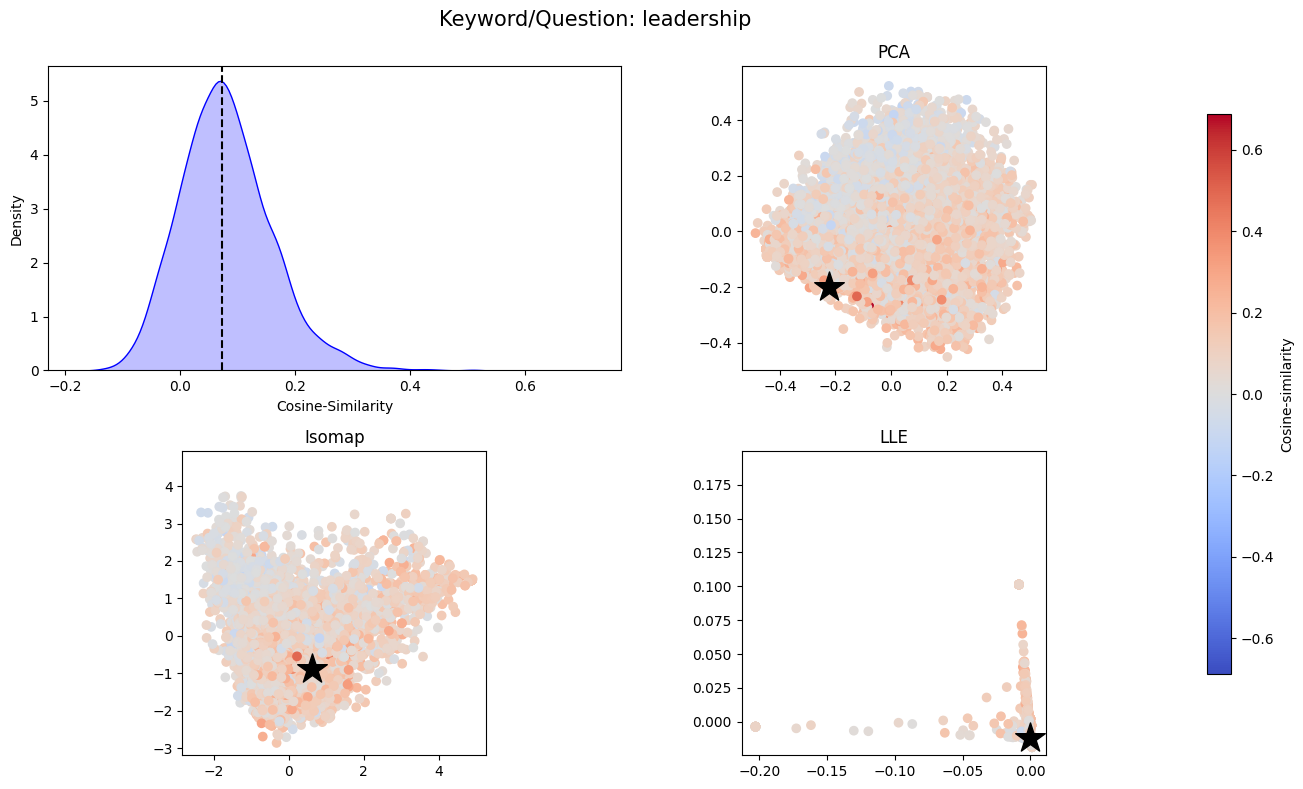

C:\Users\peter\AppData\Local\Temp\ipykernel_1372\3444741007.py:41: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


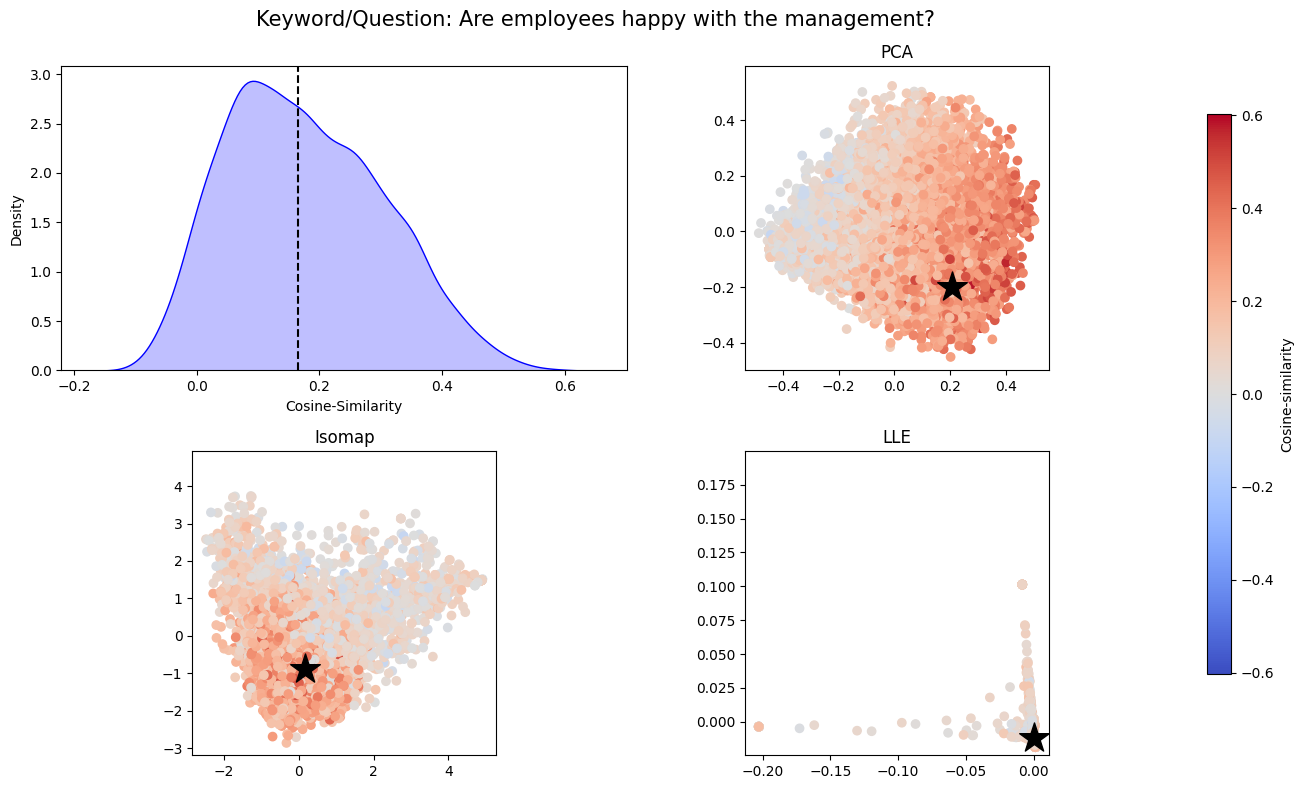

C:\Users\peter\AppData\Local\Temp\ipykernel_1372\3444741007.py:41: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


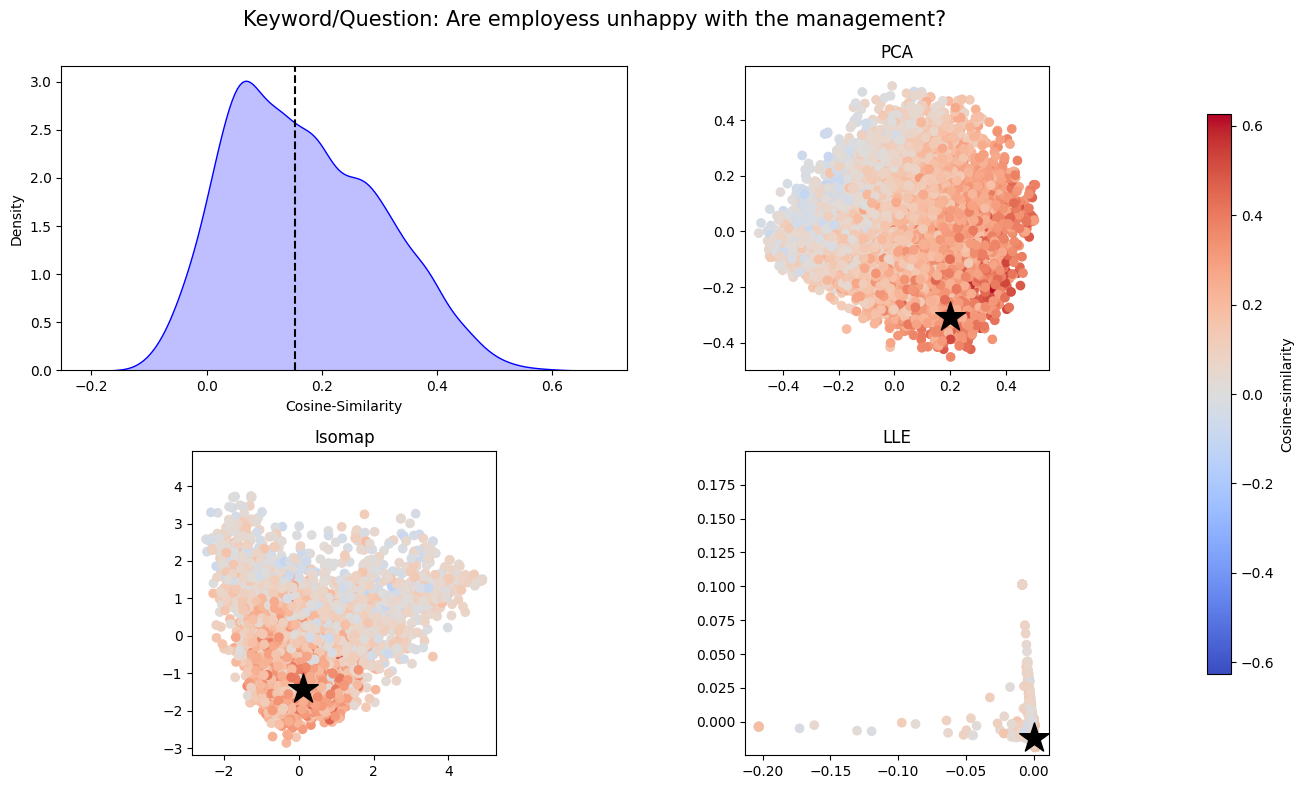

C:\Users\peter\AppData\Local\Temp\ipykernel_1372\3444741007.py:41: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


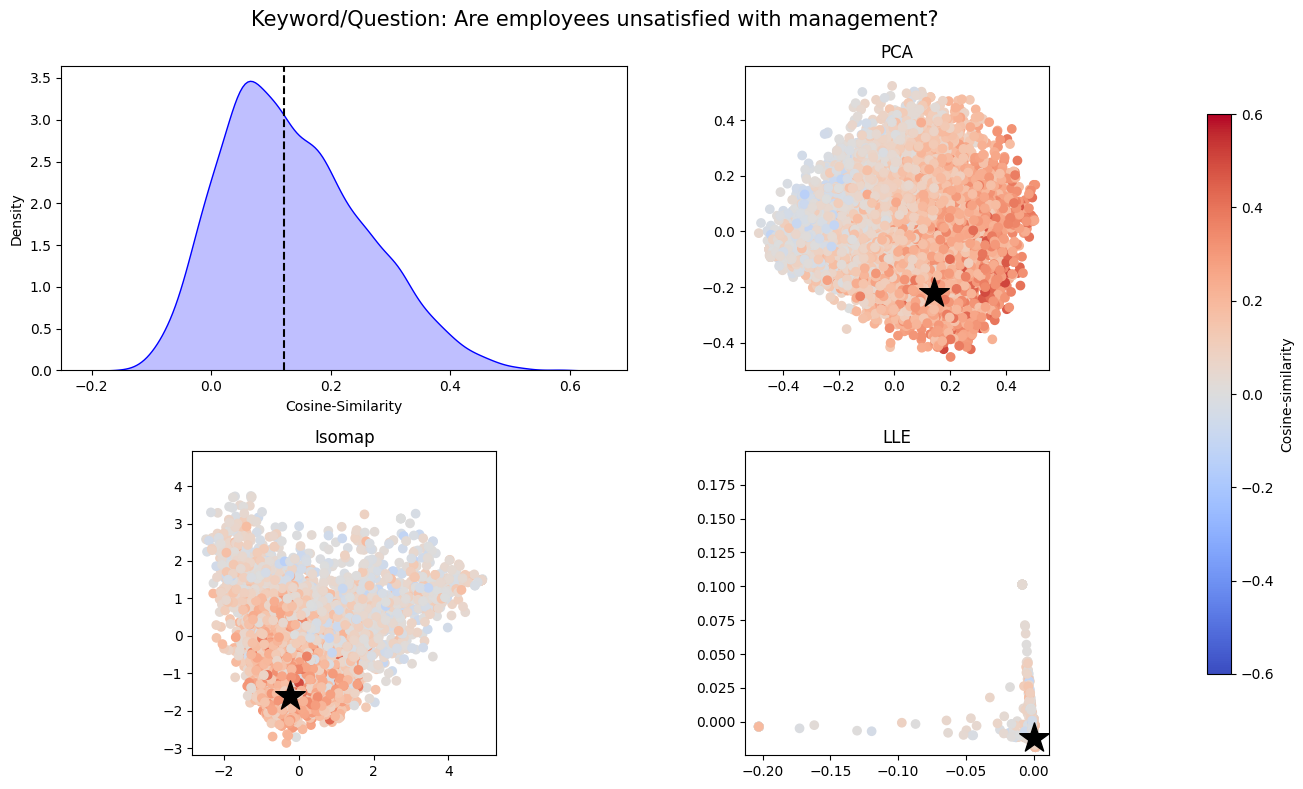

C:\Users\peter\AppData\Local\Temp\ipykernel_1372\3444741007.py:41: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


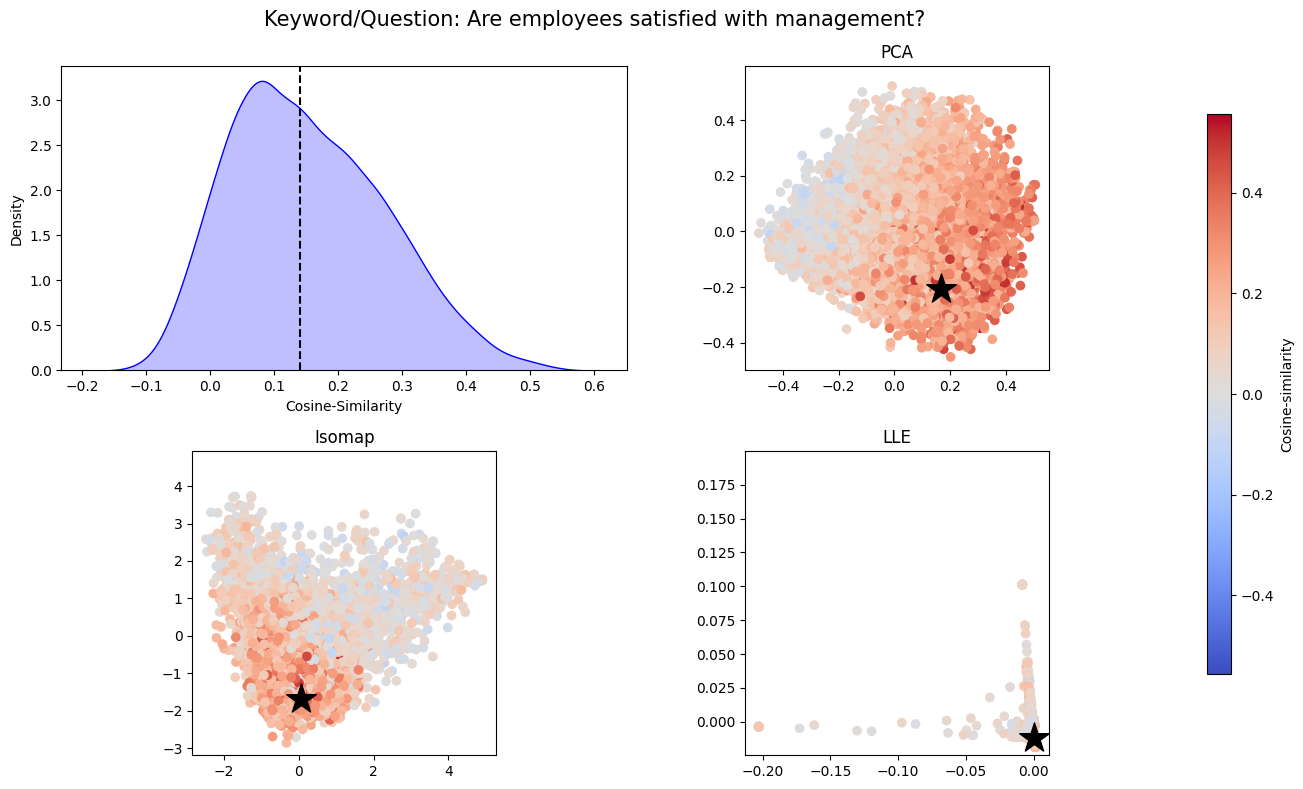

C:\Users\peter\AppData\Local\Temp\ipykernel_1372\3444741007.py:41: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


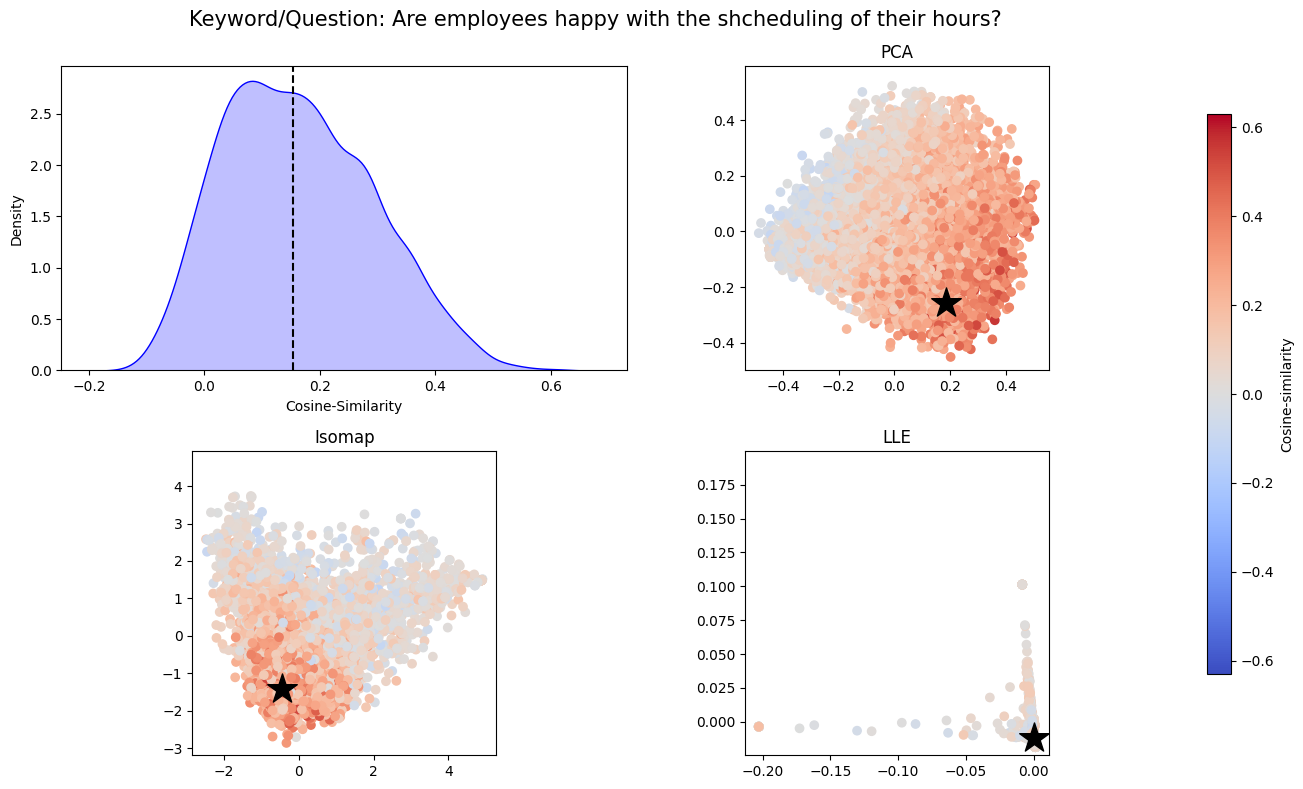

C:\Users\peter\AppData\Local\Temp\ipykernel_1372\3444741007.py:41: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


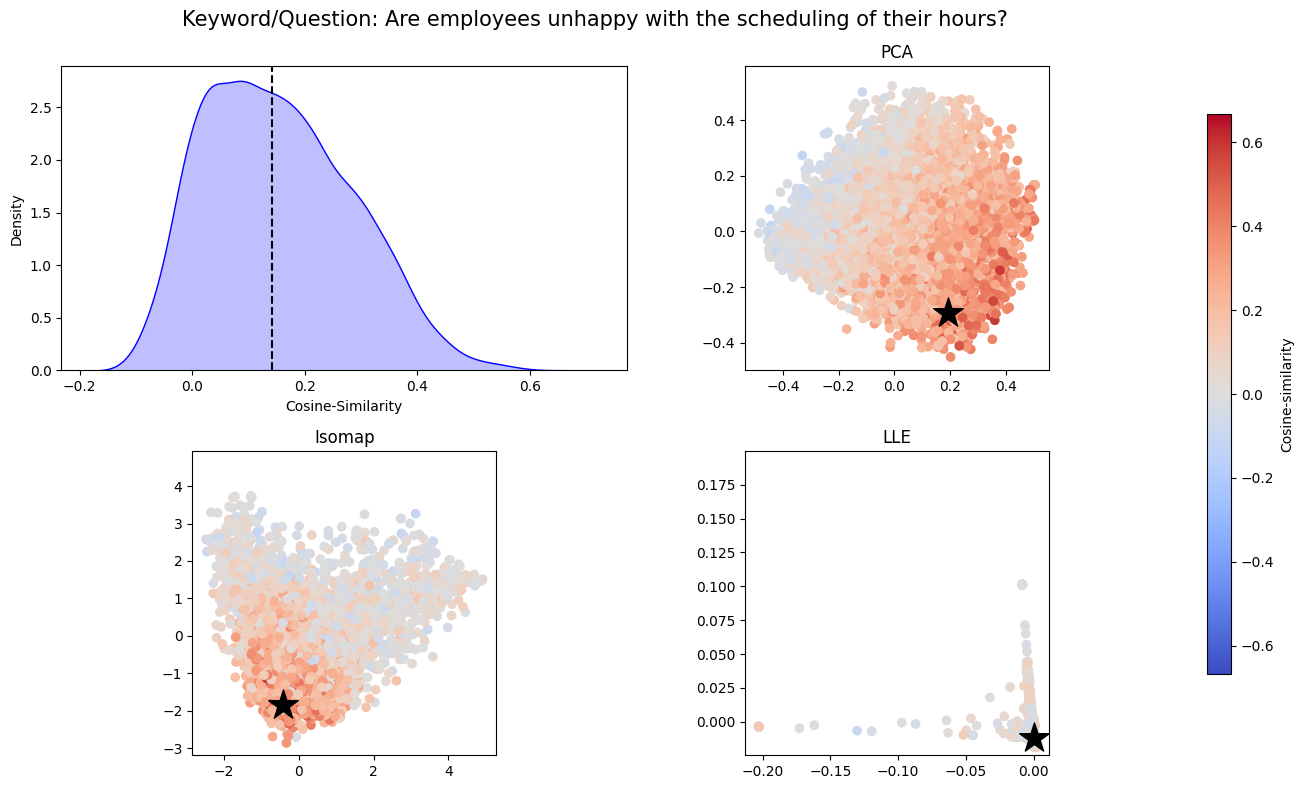

In [51]:
# for each keyword, plot the representation of the workers in 2D space, with the color of the point corresponding to the cosine similarity between the keyword and the worker statement
import matplotlib.pyplot as plt
import seaborn as sns

transformable_reductions = ['PCA', 'Isomap', 'LLE']
transformable_reducers = {name: reducer for name, reducer in reductions.items() if name in transformable_reductions}
for keyword, keyword_embedding, keyword_similarities_slice in zip(keywords, keyword_embeddings, keyword_similarities):
    dist = keyword_similarities_slice
    max_abs_dist = np.max(np.abs(dist))
    min_dist = -max_abs_dist - 0.01
    max_dist = max_abs_dist + 0.01
    
    # Create a figure with subplots
    fig = plt.figure(figsize=(12, 8))

    # Original 3D plot
    ax = fig.add_subplot(2, 2, 1)
    # Make a kde plot of the distances
    sns.kdeplot(dist, ax=ax, fill=True, color='b')
    # Add a vertical line at 0
    ax.axvline(np.median(dist), color='k', linestyle='--')
    ax.set_xlabel('Cosine-Similarity')

    

    for i, (name, reducer) in enumerate(transformable_reducers.items()):
        reduced_vectors = reduced_embeddings[name]
        reduced_u = reducer.transform([keyword_embedding])[0]

        ax = fig.add_subplot(2, 2, i + 2)
        im = ax.scatter(reduced_vectors[:, 0], reduced_vectors[:, 1], c=dist, cmap='coolwarm', vmin=min_dist, vmax=max_dist)
        ax.scatter(reduced_u[0], reduced_u[1], marker='*', color='k', s=500)
        ax.set_title(f'{name}')
        ax.axis('square')
    title_str = f'Keyword/Question: {keyword}'
    fig.suptitle(title_str, fontsize=15)
    # Add colorbar to the figure with title "Cosine-similarity" on the right
    cax = fig.add_axes([1.01, 0.15, 0.02, 0.7])  # Adjust the position of the colorbar
    fig.colorbar(im, cax=cax, label='Cosine-similarity')
    # Show the plots
    plt.tight_layout()
    plt.show()

## Create System for Evaluating Clustering "Labels"

In [83]:
from sklearn.cluster import AgglomerativeClustering, KMeans, DBSCAN, HDBSCAN

In [ ]:
cluster_methods = {
    'Agglomerative Clustering': AgglomerativeClustering(n_clusters=2),
    'KMeans': KMeans(n_clusters=2),
    'DBSCAN': DBSCAN(eps=0.5, metric='cosine'),
    'HDBSCAN': HDBSCAN(min_cluster_size=5)
}

In [470]:
from sklearn.metrics import log_loss, homogeneity_score, v_measure_score, completeness_score
from typing import Dict
def calc_prob(label_list: pd.Series, unique_labels = [-1,1,0]) -> pd.Series:
    output = (label_list.value_counts()/label_list.value_counts().sum()).reset_index()
    output = pd.merge(output, pd.DataFrame({'label':unique_labels}), how='outer').fillna(0).sort_values('label').set_index('label')
    return output.values.T[0].tolist()

def calc_mode(label_list: pd.Series) -> pd.Series:
    return pd.Series([np.mean(val) for val in label_list.mode().values])

def calc_metrics(df_labeled) -> Dict[str, float]:
    #cluster_pred = df_labeled[['cluster','label']].groupby('cluster').agg(calc_mode).reset_index().rename(columns={'label':'cluster_pred'})
    cluster_probs = df_labeled[['cluster','label']].groupby('cluster').agg(calc_prob).reset_index().rename(columns={'label':'cluster_probs'})
    if 'cluster_probs' in df_labeled.columns:
        df_labeled = df_labeled.drop(columns=['cluster_probs'])
    #if 'cluster_pred' in df_labeled.columns:
    #    df_labeled = df_labeled.drop(columns=['cluster_pred'])
    df_labeled = df_labeled.merge(cluster_probs, on='cluster')
    #df_labeled = df_labeled.merge(cluster_pred, on='cluster')
    cluster_probs = np.array([np.array(row) for row in df_labeled.cluster_probs.values])
    
    return {
        'homogeneity': homogeneity_score(df_labeled['label'], df_labeled['cluster']),
        'completeness': completeness_score(df_labeled['label'], df_labeled['cluster']),
        'v_measure': v_measure_score(df_labeled['label'], df_labeled['cluster']),
        'cross-entropy': log_loss(df_labeled.label.values, cluster_probs, labels=[-1,0,1]),
    }

In [1]:
! pip install langchain-experimental

   ---------------------------------------- 0.0/193.4 kB ? eta -:--:--
   -------- ------------------------------ 41.0/193.4 kB 991.0 kB/s eta 0:00:01
   -------------------------------------- - 184.3/193.4 kB 2.8 MB/s eta 0:00:01
   ---------------------------------------- 193.4/193.4 kB 1.9 MB/s eta 0:00:00
   ---------------------------------------- 0.0/817.7 kB ? eta -:--:--
   --------------------------------------  809.0/817.7 kB 25.8 MB/s eta 0:00:01
   --------------------------------------- 817.7/817.7 kB 17.2 MB/s eta 0:00:00
   ---------------------------------------- 0.0/299.3 kB ? eta -:--:--
   ---------------------------------------- 299.3/299.3 kB ? eta 0:00:00
   ---------------------------------------- 0.0/1.9 MB ? eta -:--:--
   ---------------------------------- ----- 1.7/1.9 MB 35.1 MB/s eta 0:00:01
   ---------------------------------------- 1.9/1.9 MB 30.5 MB/s eta 0:00:00
  Attempting uninstall: langchain-core
    Found existing installation: langchain-core 0.1.

In [3]:
!pip show langchain-experimental

Name: langchain-experimental
Version: 0.0.57
Summary: Building applications with LLMs through composability
Home-page: https://github.com/langchain-ai/langchain
Author: 
Author-email: 
License: MIT
Location: C:\Users\Peter\AppData\Local\Continuum\anaconda3\envs\reddit-rag\Lib\site-packages
Requires: langchain, langchain-core
Required-by: 


In [476]:
reduced_embeddings['none'] = embeddings

In [91]:
labeled_ids = df_all[~df_all.label.isna()].chunk_id.values
print(len(labeled_ids))
labeled_embeddings = embeddings[labeled_ids]
labels = df_all[df_all.chunk_id.isin(labeled_ids)].label.values

686


In [477]:
reduction_name = 'none'
reduced_vectors = reduced_embeddings[reduction_name]

In [479]:
reduced_vectors.shape[1]

768

In [487]:
labeled_ids

array([   4,   15,   26,   29,   31,   32,   33,   34,   51,   53,   70,
         84,   87,   93,   94,  105,  119,  122,  128,  129,  144,  170,
        174,  180,  186,  192,  193,  202,  203,  217,  222,  230,  237,
        239,  243,  246,  249,  251,  255,  257,  260,  274,  306,  310,
        313,  323,  324,  330,  342,  344,  345,  346,  349,  358,  373,
        374,  379,  396,  404,  414,  415,  419,  430,  433,  469,  474,
        478,  488,  504,  505,  521,  527,  540,  542,  545,  563,  585,
        595,  634,  650,  651,  666,  667,  672,  674,  685,  686,  705,
        718,  725,  736,  739,  747,  748,  761,  762,  763,  771,  774,
        786,  787,  797,  798,  814,  817,  820,  821,  827,  831,  835,
        843,  844,  849,  851,  854,  865,  866,  870,  881,  890,  892,
        893,  894,  902,  907,  913,  925,  930,  932,  937,  938,  940,
        943,  945,  946,  948,  957,  969,  999, 1000, 1015, 1023, 1025,
       1033, 1035, 1049, 1054, 1056, 1062, 1064, 10

In [495]:
df_labeled

label                                             reason  \
3     -1.0  The statement implies dissatisfaction with the...   
411    0.0  The statement does not indicate any satisfacti...   
392   -1.0  The statement does not indicate any satisfacti...   
163    0.0  The statement does not indicate whether the em...   
220    1.0  The statement indicates a positive experience ...   
..     ...                                                ...   
528   -1.0  The statement suggests that the employee is un...   
385    1.0  The statement 'thank you i appreciate it!' ind...   
293   -1.0  The statement suggests a lack of satisfaction ...   
495    0.0  The statement provided does not give any indic...   
292   -1.0  The statement implies dissatisfaction with lea...   

                                                output  \
3     {\n    "label": -1,\n    "reason": "The state...   
411   {\n  "label": 0,\n  "reason": "The statement ...   
392   {\n  "label": -1,\n  "reason": "The statement...   
163   {\n  "label": 0,\n  "reason": "The statement ...   
220   {\n  "label": 1,\n  "reason": "The statement ...   
..                                                 ...   
528   {\n  "label": -1,\n  "reason": "The statement...   
385   {\n  "label": 1,\n  "reason": "The statement ...   
293   {\n  "label": -1,\n  "reason": "The statement...   
495   {\n  "label": 0,\n  "reason": "The statement ...   
292   {\n  "label": -1,\n  "reason": "The statement...   

                                             statement  chunk_id  \
3    I was there almost 5 years before my position ...         4   
411  It’s moderated, but unless you’re violating a ...        15   
392  🤣🤣 thank you for the advice. Mind elaborating ...        26   
163  Just got the interview for a Best Buy associat...        29   
220  It always depends on the store environment and...        31   
..                                                 ...       ...   
528  Aw shucks! I’m still waiting to see if I get t...      5643   
385                        thank you i appreciate it !      5646   
293  well if anything i hope you make it ! our mark...      5650   
495  then you definitely have nothing to worry about !      5652   
292       What has leadership done to deserve a bonus?      5664   

                                              question reddit_id  \
3    Does this statement reflect sentiment about Be...   12m0ozl   
411  Does this statement reflect sentiment about Be...   iwjm5pw   
392  Does this statement reflect sentiment about Be...   iwshpu5   
163  Does this statement reflect sentiment about Be...   j99zl57   
220  Does this statement reflect sentiment about Be...   j99eff3   
..                                                 ...       ...   
528  Does this statement reflect sentiment about Be...   isv1xln   
385  Does this statement reflect sentiment about Be...   ixb7bg8   
293  Does this statement reflect sentiment about Be...    zut2tr   
495  Does this statement reflect sentiment about Be...    y95bo3   
292  Does this statement reflect sentiment about Be...   j1y8wgf   

    aware_post_type     aware_created_ts reddit_link_id reddit_parent_id  \
3        submission  2023-04-14T11:18:57           None             None   
411         comment  2022-11-15T21:49:44      t3_yw5weg       t1_iwhuz02   
392         comment  2022-11-17T19:35:11      t3_yy085z        t3_yy085z   
163         comment  2023-02-20T06:33:23     t3_10v8unp       t1_j7ro0b6   
220         comment  2023-02-20T01:44:41     t3_10fmkvw       t3_10fmkvw   
..              ...                  ...            ...              ...   
528         comment  2022-10-18T18:20:35      t3_xu6znu        t3_xu6znu   
385         comment  2022-11-21T22:16:39      t3_z1iupm        t3_z1iupm   
293      submission  2022-12-25T02:19:34           None             None   
495      submission  2022-10-20T14:04:45           None             None   
292         comment  2022-12-28T02:31:22      t3_zwzlqi  

In [497]:
temp_df

{'chunk_id': array([   4,   15,   26,   29,   31,   32,   33,   34,   51,   53,   70,
          84,   87,   93,   94,  105,  119,  122,  128,  129,  144,  170,
         174,  180,  186,  192,  193,  202,  203,  217,  222,  230,  237,
         239,  243,  246,  249,  251,  255,  257,  260,  274,  306,  310,
         313,  323,  324,  330,  342,  344,  345,  346,  349,  358,  373,
         374,  379,  396,  404,  414,  415,  419,  430,  433,  469,  474,
         478,  488,  504,  505,  521,  527,  540,  542,  545,  563,  585,
         595,  634,  650,  651,  666,  667,  672,  674,  685,  686,  705,
         718,  725,  736,  739,  747,  748,  761,  762,  763,  771,  774,
         786,  787,  797,  798,  814,  817,  820,  821,  827,  831,  835,
         843,  844,  849,  851,  854,  865,  866,  870,  881,  890,  892,
         893,  894,  902,  907,  913,  925,  930,  932,  937,  938,  940,
         943,  945,  946,  948,  957,  969,  999, 1000, 1015, 1023, 1025,
        1033, 1035, 1049, 

In [498]:
reduction_name = 'PCA'

# Cluster only on labeled data
reduced_vectors = reduced_embeddings[reduction_name][labeled_ids,:]
clusterer_dict = {
    'AC_0.1' : AgglomerativeClustering(distance_threshold=0.1, compute_full_tree = True, n_clusters = None, linkage='complete'),
    'AC_0.3' : AgglomerativeClustering(distance_threshold=0.3, compute_full_tree = True, n_clusters = None, linkage='complete'),
    'AC_0.5' : AgglomerativeClustering(distance_threshold=0.5, compute_full_tree = True, n_clusters = None, linkage='complete'),
    'Kmeans_10': KMeans(init='k-means++', n_clusters = 10, n_init=6),
    'Kmeans_30': KMeans(init='k-means++', n_clusters = 30, n_init=6),
    'Kmeans_60': KMeans(init='k-means++', n_clusters = 60, n_init=6),
    'Kmeans_90': KMeans(init='k-means++', n_clusters = 90, n_init=30),
    'Kmeans_150': KMeans(init='k-means++', n_clusters = 150, n_init=50),

}
metric_summary = []
for name, clusterer in clusterer_dict.items():
    clusters = clusterer.fit(reduced_vectors)
    cluster_id = clusters.labels_
    temp_df = pd.DataFrame({'chunk_id':labeled_ids, 'cluster':cluster_id})
    if 'cluster' in list(df_labeled.columns):
        df_labeled = df_labeled.drop(columns='cluster')
    df_labeled = df_labeled.merge(temp_df, on='chunk_id')
    """
    index_dict = { 
        'positive' : df_labeled[df_labeled.label==1].index,
        'neutral' : df_labeled[df_labeled.label==0].index,
        'negative' : df_labeled[df_labeled.label==-1].index
    }
    markers = ['+', '.', '_']

    ax = fig.add_subplot(2, 2, subplot_id+2)
    plt.figure()
    for i, (index_name, indexes) in enumerate(index_dict.items()):
        im = plt.scatter(reduced_vectors[indexes, 0], reduced_vectors[indexes, 1], c=cluster_id[indexes], cmap='tab20c', label=index_name, marker=markers[i], s=100)
    plt.title(f'{reduction_name}')
    plt.show()
    """
    metrics_out = calc_metrics(df_labeled)
    context_dict = {
        'method':name, 
        'reduction method': reduction_name,
        '# of dimensions' : reduced_vectors.shape[1],
        '# of clusters': len(np.unique(clusters.labels_))
    }
    metric_summary.append(context_dict | metrics_out)
    display(pd.DataFrame([context_dict|metrics_out]))
pd.DataFrame(metric_summary)

method reduction method  # of dimensions  # of clusters  homogeneity  \
0  AC_0.1              PCA                2             91     0.235495   

   completeness  v_measure  cross-entropy  
0      0.043053   0.072797       0.606737

method reduction method  # of dimensions  # of clusters  homogeneity  \
0  AC_0.3              PCA                2             17     0.103092   

   completeness  v_measure  cross-entropy  
0      0.031158   0.047853       0.711817

method reduction method  # of dimensions  # of clusters  homogeneity  \
0  AC_0.5              PCA                2              7     0.053392   

   completeness  v_measure  cross-entropy  
0      0.023199   0.032344        0.75126

method reduction method  # of dimensions  # of clusters  homogeneity  \
0  Kmeans_10              PCA                2             10     0.075876   

   completeness  v_measure  cross-entropy  
0      0.026536    0.03932       0.733416

method reduction method  # of dimensions  # of clusters  homogeneity  \
0  Kmeans_30              PCA                2             30     0.120386   

   completeness  v_measure  cross-entropy  
0      0.028361   0.045906       0.698091

method reduction method  # of dimensions  # of clusters  homogeneity  \
0  Kmeans_60              PCA                2             60     0.205803   

   completeness  v_measure  cross-entropy  
0      0.040749   0.068029       0.630301

method reduction method  # of dimensions  # of clusters  homogeneity  \
0  Kmeans_90              PCA                2             90     0.242432   

   completeness  v_measure  cross-entropy  
0      0.043434   0.073669       0.601231

method reduction method  # of dimensions  # of clusters  homogeneity  \
0  Kmeans_150              PCA                2            150     0.338541   

   completeness  v_measure  cross-entropy  
0      0.054939   0.094536       0.524956

method reduction method  # of dimensions  # of clusters  homogeneity  \
0      AC_0.1              PCA                2             91     0.235495   
1      AC_0.3              PCA                2             17     0.103092   
2      AC_0.5              PCA                2              7     0.053392   
3   Kmeans_10              PCA                2             10     0.075876   
4   Kmeans_30              PCA                2             30     0.120386   
5   Kmeans_60              PCA                2             60     0.205803   
6   Kmeans_90              PCA                2             90     0.242432   
7  Kmeans_150              PCA                2            150     0.338541   

   completeness  v_measure  cross-entropy  
0      0.043053   0.072797       0.606737  
1      0.031158   0.047853       0.711817  
2      0.023199   0.032344       0.751260  
3      0.026536   0.039320       0.733416  
4      0.028361   0.045906       0.698091  
5      0.040749   0.068029       0.630301  
6      0.043434   0.073669       0.601231  
7      0.054939   0.094536       0.524956

In [501]:
reduction_name = 'Isomap'

# Cluster only on labeled data
reduced_vectors = reduced_embeddings[reduction_name][labeled_ids,:]
clusterer_dict = {
    'AC_0.1' : AgglomerativeClustering(distance_threshold=0.1, compute_full_tree = True, n_clusters = None, linkage='complete'),
    'AC_0.3' : AgglomerativeClustering(distance_threshold=0.3, compute_full_tree = True, n_clusters = None, linkage='complete'),
    'AC_0.5' : AgglomerativeClustering(distance_threshold=0.5, compute_full_tree = True, n_clusters = None, linkage='complete'),
    'Kmeans_10': KMeans(init='k-means++', n_clusters = 10, n_init=6),
    'Kmeans_30': KMeans(init='k-means++', n_clusters = 30, n_init=6),
    'Kmeans_60': KMeans(init='k-means++', n_clusters = 60, n_init=6),
    'Kmeans_90': KMeans(init='k-means++', n_clusters = 90, n_init=30),
    'Kmeans_150': KMeans(init='k-means++', n_clusters = 150, n_init=50),
    'Kmeans_500': KMeans(init='k-means++', n_clusters = 500, n_init=50),

}
metric_summary = []
for name, clusterer in clusterer_dict.items():
    clusters = clusterer.fit(reduced_vectors)
    cluster_id = clusters.labels_
    temp_df = pd.DataFrame({'chunk_id':labeled_ids, 'cluster':cluster_id})
    if 'cluster' in list(df_labeled.columns):
        df_labeled = df_labeled.drop(columns='cluster')
    df_labeled = df_labeled.merge(temp_df, on='chunk_id')
    """
    index_dict = { 
        'positive' : df_labeled[df_labeled.label==1].index,
        'neutral' : df_labeled[df_labeled.label==0].index,
        'negative' : df_labeled[df_labeled.label==-1].index
    }
    markers = ['+', '.', '_']

    ax = fig.add_subplot(2, 2, subplot_id+2)
    plt.figure()
    for i, (index_name, indexes) in enumerate(index_dict.items()):
        im = plt.scatter(reduced_vectors[indexes, 0], reduced_vectors[indexes, 1], c=cluster_id[indexes], cmap='tab20c', label=index_name, marker=markers[i], s=100)
    plt.title(f'{reduction_name}')
    plt.show()
    """
    metrics_out = calc_metrics(df_labeled)
    context_dict = {
        'method':name, 
        'reduction method': reduction_name,
        '# of dimensions' : reduced_vectors.shape[1],
        '# of clusters': len(np.unique(clusters.labels_))
    }
    metric_summary.append(context_dict | metrics_out)
    display(pd.DataFrame([context_dict|metrics_out]))
pd.DataFrame(metric_summary)

method reduction method  # of dimensions  # of clusters  homogeneity  \
0  AC_0.1           Isomap                2            361     0.640704   

   completeness  v_measure  cross-entropy  
0      0.088888   0.156118        0.28515

method reduction method  # of dimensions  # of clusters  homogeneity  \
0  AC_0.3           Isomap                2            160     0.350506   

   completeness  v_measure  cross-entropy  
0      0.058525   0.100302        0.51546

method reduction method  # of dimensions  # of clusters  homogeneity  \
0  AC_0.5           Isomap                2             89     0.225256   

   completeness  v_measure  cross-entropy  
0      0.043364   0.072727       0.614863

method reduction method  # of dimensions  # of clusters  homogeneity  \
0  Kmeans_10           Isomap                2             10     0.058239   

   completeness  v_measure  cross-entropy  
0      0.022458   0.032415       0.747413

method reduction method  # of dimensions  # of clusters  homogeneity  \
0  Kmeans_30           Isomap                2             30     0.121386   

   completeness  v_measure  cross-entropy  
0       0.02969    0.04771       0.697298

method reduction method  # of dimensions  # of clusters  homogeneity  \
0  Kmeans_60           Isomap                2             60     0.179836   

   completeness  v_measure  cross-entropy  
0      0.037276   0.061752       0.650909

method reduction method  # of dimensions  # of clusters  homogeneity  \
0  Kmeans_90           Isomap                2             90     0.224182   

   completeness  v_measure  cross-entropy  
0      0.041596   0.070173       0.615715

method reduction method  # of dimensions  # of clusters  homogeneity  \
0  Kmeans_150           Isomap                2            150     0.352709   

   completeness  v_measure  cross-entropy  
0      0.058956   0.101025       0.513712

method reduction method  # of dimensions  # of clusters  homogeneity  \
0  Kmeans_500           Isomap                2            500     0.773102   

   completeness  v_measure  cross-entropy  
0      0.100433   0.177772       0.180074

method reduction method  # of dimensions  # of clusters  homogeneity  \
0      AC_0.1           Isomap                2            361     0.640704   
1      AC_0.3           Isomap                2            160     0.350506   
2      AC_0.5           Isomap                2             89     0.225256   
3   Kmeans_10           Isomap                2             10     0.058239   
4   Kmeans_30           Isomap                2             30     0.121386   
5   Kmeans_60           Isomap                2             60     0.179836   
6   Kmeans_90           Isomap                2             90     0.224182   
7  Kmeans_150           Isomap                2            150     0.352709   
8  Kmeans_500           Isomap                2            500     0.773102   

   completeness  v_measure  cross-entropy  
0      0.088888   0.156118       0.285150  
1      0.058525   0.100302       0.515460  
2      0.043364   0.072727       0.614863  
3      0.022458   0.032415       0.747413  
4      0.029690   0.047710       0.697298  
5      0.037276   0.061752       0.650909  
6      0.041596   0.070173       0.615715  
7      0.058956   0.101025       0.513712  
8      0.100433   0.177772       0.180074

In [500]:
reduction_name = 'MDS'

# Cluster only on labeled data
reduced_vectors = reduced_embeddings[reduction_name][labeled_ids,:]
clusterer_dict = {
    'AC_0.1' : AgglomerativeClustering(distance_threshold=0.1, compute_full_tree = True, n_clusters = None, linkage='complete'),
    'AC_0.3' : AgglomerativeClustering(distance_threshold=0.3, compute_full_tree = True, n_clusters = None, linkage='complete'),
    'AC_0.5' : AgglomerativeClustering(distance_threshold=0.5, compute_full_tree = True, n_clusters = None, linkage='complete'),
    'Kmeans_10': KMeans(init='k-means++', n_clusters = 10, n_init=6),
    'Kmeans_30': KMeans(init='k-means++', n_clusters = 30, n_init=6),
    'Kmeans_60': KMeans(init='k-means++', n_clusters = 60, n_init=6),
    'Kmeans_90': KMeans(init='k-means++', n_clusters = 90, n_init=30),
    'Kmeans_150': KMeans(init='k-means++', n_clusters = 150, n_init=50),
    'Kmeans_500': KMeans(init='k-means++', n_clusters = 500, n_init=50),

}
metric_summary = []
for name, clusterer in clusterer_dict.items():
    clusters = clusterer.fit(reduced_vectors)
    cluster_id = clusters.labels_
    temp_df = pd.DataFrame({'chunk_id':labeled_ids, 'cluster':cluster_id})
    if 'cluster' in list(df_labeled.columns):
        df_labeled = df_labeled.drop(columns='cluster')
    df_labeled = df_labeled.merge(temp_df, on='chunk_id')
    """
    index_dict = { 
        'positive' : df_labeled[df_labeled.label==1].index,
        'neutral' : df_labeled[df_labeled.label==0].index,
        'negative' : df_labeled[df_labeled.label==-1].index
    }
    markers = ['+', '.', '_']

    ax = fig.add_subplot(2, 2, subplot_id+2)
    plt.figure()
    for i, (index_name, indexes) in enumerate(index_dict.items()):
        im = plt.scatter(reduced_vectors[indexes, 0], reduced_vectors[indexes, 1], c=cluster_id[indexes], cmap='tab20c', label=index_name, marker=markers[i], s=100)
    plt.title(f'{reduction_name}')
    plt.show()
    """
    metrics_out = calc_metrics(df_labeled)
    context_dict = {
        'method':name, 
        'reduction method': reduction_name,
        '# of dimensions' : reduced_vectors.shape[1],
        '# of clusters': len(np.unique(clusters.labels_))
    }
    metric_summary.append(context_dict | metrics_out)
    display(pd.DataFrame([context_dict|metrics_out]))
pd.DataFrame(metric_summary)

method reduction method  # of dimensions  # of clusters  homogeneity  \
0  AC_0.1              MDS                2            238     0.547806   

   completeness  v_measure  cross-entropy  
0      0.082121    0.14283       0.358877

method reduction method  # of dimensions  # of clusters  homogeneity  \
0  AC_0.3              MDS                2             70     0.260693   

   completeness  v_measure  cross-entropy  
0      0.051966   0.086657       0.586739

method reduction method  # of dimensions  # of clusters  homogeneity  \
0  AC_0.5              MDS                2             37     0.180696   

   completeness  v_measure  cross-entropy  
0      0.042607   0.068954       0.650227

method reduction method  # of dimensions  # of clusters  homogeneity  \
0  Kmeans_10              MDS                2             10     0.098781   

   completeness  v_measure  cross-entropy  
0      0.036086   0.052861       0.715238

method reduction method  # of dimensions  # of clusters  homogeneity  \
0  Kmeans_30              MDS                2             30     0.176956   

   completeness  v_measure  cross-entropy  
0      0.043301   0.069577       0.653196

method reduction method  # of dimensions  # of clusters  homogeneity  \
0  Kmeans_60              MDS                2             60      0.23974   

   completeness  v_measure  cross-entropy  
0      0.048222   0.080294       0.603368

method reduction method  # of dimensions  # of clusters  homogeneity  \
0  Kmeans_90              MDS                2             90     0.293995   

   completeness  v_measure  cross-entropy  
0      0.053872   0.091059       0.560309

method reduction method  # of dimensions  # of clusters  homogeneity  \
0  Kmeans_150              MDS                2            150     0.390217   

   completeness  v_measure  cross-entropy  
0      0.064132   0.110159       0.483945

method reduction method  # of dimensions  # of clusters  homogeneity  \
0  Kmeans_500              MDS                2            500      0.84847   

   completeness  v_measure  cross-entropy  
0      0.110342   0.195286        0.12026

method reduction method  # of dimensions  # of clusters  homogeneity  \
0      AC_0.1              MDS                2            238     0.547806   
1      AC_0.3              MDS                2             70     0.260693   
2      AC_0.5              MDS                2             37     0.180696   
3   Kmeans_10              MDS                2             10     0.098781   
4   Kmeans_30              MDS                2             30     0.176956   
5   Kmeans_60              MDS                2             60     0.239740   
6   Kmeans_90              MDS                2             90     0.293995   
7  Kmeans_150              MDS                2            150     0.390217   
8  Kmeans_500              MDS                2            500     0.848470   

   completeness  v_measure  cross-entropy  
0      0.082121   0.142830       0.358877  
1      0.051966   0.086657       0.586739  
2      0.042607   0.068954       0.650227  
3      0.036086   0.052861       0.715238  
4      0.043301   0.069577       0.653196  
5      0.048222   0.080294       0.603368  
6      0.053872   0.091059       0.560309  
7      0.064132   0.110159       0.483945  
8      0.110342   0.195286       0.120260

C:\Users\peter\AppData\Local\Temp\ipykernel_1372\1700001118.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_labeled['cluster'] = cluster_id


{'homogeneity': 0.23549472254688414, 'completeness': 0.04305284071901943, 'v_measure': 0.07279702368318464, 'cross-entropy': 0.6067371225373864}
686
(686, 2)


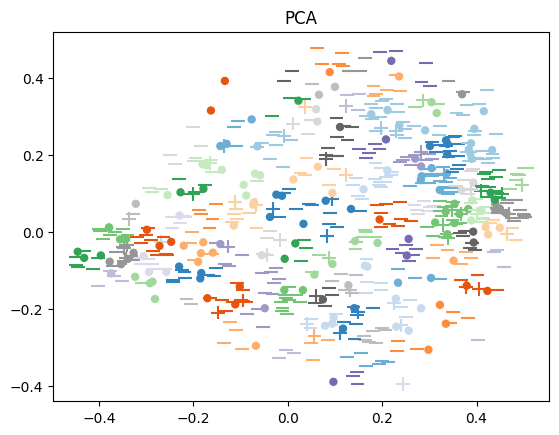

C:\Users\peter\AppData\Local\Temp\ipykernel_1372\1700001118.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_labeled['cluster'] = cluster_id


{'homogeneity': 0.6407037369260491, 'completeness': 0.08888847974455891, 'v_measure': 0.15611784183198407, 'cross-entropy': 0.2851496088060612}
686
(686, 2)


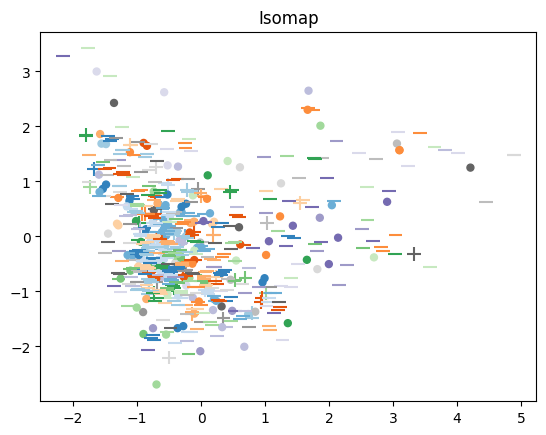

C:\Users\peter\AppData\Local\Temp\ipykernel_1372\1700001118.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_labeled['cluster'] = cluster_id


{'homogeneity': 0.5478057525344147, 'completeness': 0.0821207885954876, 'v_measure': 0.14283011576104934, 'cross-entropy': 0.358876576299441}
686
(686, 2)


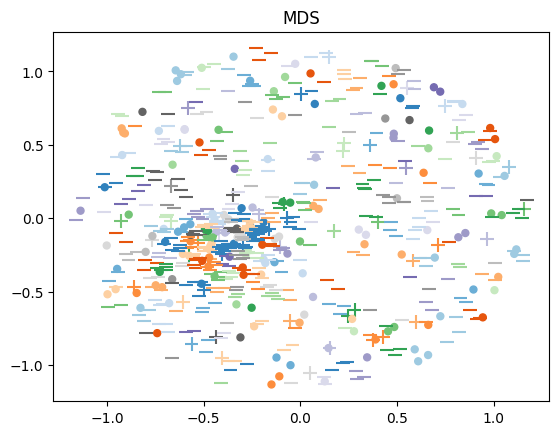

In [493]:
reduction_name = 'PCA'
for reduction_name in ['PCA', 'Isomap', 'MDS']:
    reduced_vectors = reduced_embeddings[reduction_name][labeled_ids,:]
    clusterer = AgglomerativeClustering(distance_threshold=0.1, compute_full_tree = True, n_clusters = None, linkage='complete')
    clusters = clusterer.fit(reduced_vectors)
    cluster_id = clusters.labels_
    df_labeled['cluster'] = cluster_id
    print(calc_metrics(df_labeled))
    print(len(cluster_id))
    print(reduced_vectors.shape)
    index_dict = { 
        'positive' : df_labeled[df_labeled.label==1].index,
        'neutral' : df_labeled[df_labeled.label==0].index,
        'negative' : df_labeled[df_labeled.label==-1].index
    }
    markers = ['+', '.', '_']

    ax = fig.add_subplot(2, 2, subplot_id+2)
    plt.figure()
    for i, (index_name, indexes) in enumerate(index_dict.items()):
        im = plt.scatter(reduced_vectors[indexes, 0], reduced_vectors[indexes, 1], c=cluster_id[indexes], cmap='tab20c', label=index_name, marker=markers[i], s=100)
    plt.title(f'{reduction_name}')
    plt.show()
    

In [ ]:
reduction_names = ['Isomap', 'PCA', 'MDS']
cluster_id = df_all.sort_values('chunk_id').cluster

fig = plt.figure(figsize=(10,10))

cluster_sizes = cluster_id.reset_index().groupby('cluster').count()
ax = fig.add_subplot(2, 2, 1)
# Make a histogram of cluster sizes
plt.hist(cluster_sizes.values, bins=list(np.linspace(0, cluster_sizes.max().values+1, 15).T[0]), color='b', alpha=0.7)
# Add a vertical line at 0
ax.set_xlabel('Cluster Size')
ax.set_ylabel('Count')

for subplot_id, reduction_name in enumerate(reduction_names):
    reduced_vectors = reduced_embeddings[reduction_name][labeled_ids,:]

    index_dict = { 
        'positive' : df_all[df_all.label==1].chunk_id.values,
        'neutral' : df_all[df_all.label==0].chunk_id.values,
        'negative' : df_all[df_all.label==-1].chunk_id.values
    }
    markers = ['+', '.', '_']

    ax = fig.add_subplot(2, 2, subplot_id+2)

    for i, (index_name, indexes) in enumerate(index_dict.items()):
        im = ax.scatter(reduced_vectors[indexes, 0], reduced_vectors[indexes, 1], c=cluster_id[indexes], cmap='tab20c', label=index_name, marker=markers[i], s=100)
    ax.set_title(f'{reduction_name}')
plt.legend()
plt.show()

In [480]:
reduction_name = 'PCA'
reduced_vectors = reduced_embeddings[reduction_name]
clusterer_dict = {
    'AC_0.1' : AgglomerativeClustering(distance_threshold=0.1, compute_full_tree = True, n_clusters = None, linkage='complete'),
    'AC_0.3' : AgglomerativeClustering(distance_threshold=0.3, compute_full_tree = True, n_clusters = None, linkage='complete'),
    'AC_0.5' : AgglomerativeClustering(distance_threshold=0.5, compute_full_tree = True, n_clusters = None, linkage='complete'),
    'Kmeans_10': KMeans(init='k-means++', n_clusters = 10, n_init=6),
    'Kmeans_30': KMeans(init='k-means++', n_clusters = 30, n_init=6),
    'Kmeans_60': KMeans(init='k-means++', n_clusters = 60, n_init=6),
    'Kmeans_90': KMeans(init='k-means++', n_clusters = 90, n_init=30),
    'Kmeans_150': KMeans(init='k-means++', n_clusters = 150, n_init=50),
    'Kmeans_300': KMeans(init='k-means++', n_clusters = 300, n_init=100),
    'Kmeans_1000': KMeans(init='k-means++', n_clusters = 1000, n_init=100),

}
metric_summary = []
for name, clusterer in clusterer_dict.items():
    clusters = clusterer.fit(reduced_vectors)
    df_all['cluster'] = clusters.labels_
    df_labeled = df_all[~df_all.label.isna()]
    metrics_out = calc_metrics(df_labeled)
    context_dict = {
        'method':name, 
        'reduction method': reduction_name,
        '# of dimensions' : reduced_vectors.shape[1],
        '# of clusters': len(np.unique(clusters.labels_))
    }
    metric_summary.append(context_dict | metrics_out)
    display(pd.DataFrame([context_dict|metrics_out]))
pd.DataFrame(metric_summary)

method reduction method  # of dimensions  # of clusters  homogeneity  \
0  AC_0.1              PCA                2            300     0.327034   

   completeness  v_measure  cross-entropy  
0      0.055227   0.094496       0.534089

method reduction method  # of dimensions  # of clusters  homogeneity  \
0  AC_0.3              PCA                2            152     0.117833   

   completeness  v_measure  cross-entropy  
0      0.031813     0.0501       0.700117

method reduction method  # of dimensions  # of clusters  homogeneity  \
0  AC_0.5              PCA                2             25     0.077904   

   completeness  v_measure  cross-entropy  
0      0.032988    0.04635       0.731807

method reduction method  # of dimensions  # of clusters  homogeneity  \
0  Kmeans_10              PCA                2              8     0.072889   

   completeness  v_measure  cross-entropy  
0       0.02708   0.039489       0.735787

method reduction method  # of dimensions  # of clusters  homogeneity  \
0  Kmeans_30              PCA                2             10     0.142966   

   completeness  v_measure  cross-entropy  
0      0.035519   0.056901       0.680171

method reduction method  # of dimensions  # of clusters  homogeneity  \
0  Kmeans_60              PCA                2             30     0.201785   

   completeness  v_measure  cross-entropy  
0      0.041575   0.068944        0.63349

method reduction method  # of dimensions  # of clusters  homogeneity  \
0  Kmeans_90              PCA                2             60     0.245591   

   completeness  v_measure  cross-entropy  
0      0.045752   0.077135       0.598724

method reduction method  # of dimensions  # of clusters  homogeneity  \
0  Kmeans_150              PCA                2             90     0.347063   

   completeness  v_measure  cross-entropy  
0      0.058744   0.100481       0.518193

method reduction method  # of dimensions  # of clusters  homogeneity  \
0  Kmeans_300              PCA                2            150     0.485127   

   completeness  v_measure  cross-entropy  
0      0.073402   0.127511        0.40862

method reduction method  # of dimensions  # of clusters  homogeneity  \
0  Kmeans_1000              PCA                2            300      0.76601   

   completeness  v_measure  cross-entropy  
0      0.101067   0.178573       0.185703

method reduction method  # of dimensions  # of clusters  homogeneity  \
0       AC_0.1              PCA                2            300     0.327034   
1       AC_0.3              PCA                2            152     0.117833   
2       AC_0.5              PCA                2             25     0.077904   
3    Kmeans_10              PCA                2              8     0.072889   
4    Kmeans_30              PCA                2             10     0.142966   
5    Kmeans_60              PCA                2             30     0.201785   
6    Kmeans_90              PCA                2             60     0.245591   
7   Kmeans_150              PCA                2             90     0.347063   
8   Kmeans_300              PCA                2            150     0.485127   
9  Kmeans_1000              PCA                2            300     0.766010   

   completeness  v_measure  cross-entropy  
0      0.055227   0.094496       0.534089  
1      0.031813   0.050100       0.700117  
2      0.032988   0.046350       0.731807  
3      0.027080   0.039489       0.735787  
4      0.035519   0.056901       0.680171  
5      0.041575   0.068944       0.633490  
6      0.045752   0.077135       0.598724  
7      0.058744   0.100481       0.518193  
8      0.073402   0.127511       0.408620  
9      0.101067   0.178573       0.185703

In [481]:
reduction_name = 'MDS'
reduced_vectors = reduced_embeddings[reduction_name]
clusterer_dict = {
    'AC_0.1' : AgglomerativeClustering(distance_threshold=0.1, compute_full_tree = True, n_clusters = None, linkage='complete'),
    'AC_0.3' : AgglomerativeClustering(distance_threshold=0.3, compute_full_tree = True, n_clusters = None, linkage='complete'),
    'AC_0.5' : AgglomerativeClustering(distance_threshold=0.5, compute_full_tree = True, n_clusters = None, linkage='complete'),
    'Kmeans_10': KMeans(init='k-means++', n_clusters = 10, n_init=6),
    'Kmeans_30': KMeans(init='k-means++', n_clusters = 30, n_init=6),
    'Kmeans_60': KMeans(init='k-means++', n_clusters = 60, n_init=6),
    'Kmeans_90': KMeans(init='k-means++', n_clusters = 90, n_init=30),
    'Kmeans_150': KMeans(init='k-means++', n_clusters = 150, n_init=50),
    'Kmeans_300': KMeans(init='k-means++', n_clusters = 300, n_init=100),
    'Kmeans_1000': KMeans(init='k-means++', n_clusters = 1000, n_init=100),

}
for name, clusterer in clusterer_dict.items():
    context_dict = {
        'method':name, 
        'reduction method': reduction_name,
        '# of dimensions' : reduced_vectors.shape[1],
        '# of clusters': len(np.unique(clusters.labels_))
    }
    clusters = clusterer.fit(reduced_vectors)
    df_all['cluster'] = clusters.labels_
    df_labeled = df_all[~df_all.label.isna()]
    metrics_out = calc_metrics(df_labeled)
    metric_summary.append(context_dict | metrics_out)
    display(pd.DataFrame([context_dict|metrics_out]))
pd.DataFrame(metric_summary)

method reduction method  # of dimensions  # of clusters  homogeneity  \
0  AC_0.1              MDS                2           1000     0.689096   

   completeness  v_measure  cross-entropy  
0      0.097083   0.170189       0.246744

method reduction method  # of dimensions  # of clusters  homogeneity  \
0  AC_0.3              MDS                2            688     0.322246   

   completeness  v_measure  cross-entropy  
0      0.058568   0.099121       0.537888

method reduction method  # of dimensions  # of clusters  homogeneity  \
0  AC_0.5              MDS                2            127     0.206455   

   completeness  v_measure  cross-entropy  
0      0.044543   0.073276       0.629784

method reduction method  # of dimensions  # of clusters  homogeneity  \
0  Kmeans_10              MDS                2             56     0.113082   

   completeness  v_measure  cross-entropy  
0      0.042143   0.061402       0.703888

method reduction method  # of dimensions  # of clusters  homogeneity  \
0  Kmeans_30              MDS                2             10     0.175644   

   completeness  v_measure  cross-entropy  
0      0.044511   0.071024       0.654236

method reduction method  # of dimensions  # of clusters  homogeneity  \
0  Kmeans_60              MDS                2             30     0.212833   

   completeness  v_measure  cross-entropy  
0      0.044828   0.074058       0.624722

method reduction method  # of dimensions  # of clusters  homogeneity  \
0  Kmeans_90              MDS                2             60     0.266174   

   completeness  v_measure  cross-entropy  
0      0.051083   0.085716       0.582389

method reduction method  # of dimensions  # of clusters  homogeneity  \
0  Kmeans_150              MDS                2             90      0.36476   

   completeness  v_measure  cross-entropy  
0      0.063319   0.107907       0.504148

method reduction method  # of dimensions  # of clusters  homogeneity  \
0  Kmeans_300              MDS                2            150     0.552302   

   completeness  v_measure  cross-entropy  
0      0.084797   0.147022       0.355308

method reduction method  # of dimensions  # of clusters  homogeneity  \
0  Kmeans_1000              MDS                2            300     0.751126   

   completeness  v_measure  cross-entropy  
0      0.101788   0.179281       0.197515

method reduction method  # of dimensions  # of clusters  homogeneity  \
0        AC_0.1              PCA                2            300     0.327034   
1        AC_0.3              PCA                2            152     0.117833   
2        AC_0.5              PCA                2             25     0.077904   
3     Kmeans_10              PCA                2              8     0.072889   
4     Kmeans_30              PCA                2             10     0.142966   
5     Kmeans_60              PCA                2             30     0.201785   
6     Kmeans_90              PCA                2             60     0.245591   
7    Kmeans_150              PCA                2             90     0.347063   
8    Kmeans_300              PCA                2            150     0.485127   
9   Kmeans_1000              PCA                2            300     0.766010   
10       AC_0.1              MDS                2           1000     0.689096   
11       AC_0.3              MDS                2            688     0.322246   
12       AC_0.5              MDS                2            127     0.206455   
13    Kmeans_10              MDS                2             56     0.113082   
14    Kmeans_30              MDS                2             10     0.175644   
15    Kmeans_60              MDS                2             30     0.212833   
16    Kmeans_90              MDS                2             60     0.266174   
17   Kmeans_150              MDS                2             90     0.364760   
18   Kmeans_300              MDS                2            150     0.552302   
19  Kmeans_1000              MDS                2            300     0.751126   

    completeness  v_measure  cross-entropy  
0       0.055227   0.094496       0.534089  
1       0.031813   0.050100       0.700117  
2       0.032988   0.046350       0.731807  
3       0.027080   0.039489       0.735787  
4       0.035519   0.056901       0.680171  
5       0.041575   0.068944       0.633490  
6       0.045752   0.077135       0.598724  
7       0.058744   0.100481       0.518193  
8       0.073402   0.127511       0.408620  
9       0.101067   0.178573       0.185703  
10      0.097083   0.170189       0.246744  
11      0.058568   0.099121       0.537888  
12      0.044543   0.073276       0.629784  
13      0.042143   0.061402       0.703888  
14      0.044511   0.071024       0.654236  
15      0.044828   0.074058       0.624722  
16      0.051083   0.085716       0.582389  
17      0.063319   0.107907       0.504148  
18      0.084797   0.147022       0.355308  
19      0.101788   0.179281       0.197515

In [482]:
reduction_name = 'none'
reduced_vectors = reduced_embeddings[reduction_name]
clusterer_dict = {
    'AC_0.1' : AgglomerativeClustering(distance_threshold=0.1, compute_full_tree = True, n_clusters = None, linkage='complete'),
    'AC_0.3' : AgglomerativeClustering(distance_threshold=0.3, compute_full_tree = True, n_clusters = None, linkage='complete'),
    'AC_0.5' : AgglomerativeClustering(distance_threshold=0.5, compute_full_tree = True, n_clusters = None, linkage='complete'),
    'Kmeans_10': KMeans(init='k-means++', n_clusters = 10, n_init=6),
    'Kmeans_30': KMeans(init='k-means++', n_clusters = 30, n_init=6),
    'Kmeans_60': KMeans(init='k-means++', n_clusters = 60, n_init=6),
    'Kmeans_90': KMeans(init='k-means++', n_clusters = 90, n_init=30),
    'Kmeans_150': KMeans(init='k-means++', n_clusters = 150, n_init=50),
    'Kmeans_300': KMeans(init='k-means++', n_clusters = 300, n_init=100),
    'Kmeans_1000': KMeans(init='k-means++', n_clusters = 1000, n_init=100),

}
for name, clusterer in clusterer_dict.items():
    clusters = clusterer.fit(reduced_vectors)
    df_all['cluster'] = clusters.labels_
    context_dict = {
        'method':name, 
        'reduction method': reduction_name,
        '# of dimensions' : reduced_vectors.shape[1],
        '# of clusters': len(np.unique(clusters.labels_))
    }
    df_labeled = df_all[~df_all.label.isna()]
    metrics_out = calc_metrics(df_labeled)
    metric_summary.append(context_dict | metrics_out)
    display(pd.DataFrame([context_dict|metrics_out]))
pd.DataFrame(metric_summary)

method reduction method  # of dimensions  # of clusters  homogeneity  \
0  AC_0.1             none              768           1000          1.0   

   completeness  v_measure  cross-entropy  
0      0.121633   0.216886   4.440892e-16

method reduction method  # of dimensions  # of clusters  homogeneity  \
0  AC_0.3             none              768           5578          1.0   

   completeness  v_measure  cross-entropy  
0      0.121633   0.216886   4.440892e-16

method reduction method  # of dimensions  # of clusters  homogeneity  \
0  AC_0.5             none              768           5577          1.0   

   completeness  v_measure  cross-entropy  
0      0.121709   0.217006   4.440892e-16

method reduction method  # of dimensions  # of clusters  homogeneity  \
0  Kmeans_10             none              768           5562       0.1264   

   completeness  v_measure  cross-entropy  
0      0.047788   0.069355       0.693318

method reduction method  # of dimensions  # of clusters  homogeneity  \
0  Kmeans_30             none              768             10     0.183332   

   completeness  v_measure  cross-entropy  
0      0.047961   0.076031       0.648136

method reduction method  # of dimensions  # of clusters  homogeneity  \
0  Kmeans_60             none              768             30     0.257964   

   completeness  v_measure  cross-entropy  
0      0.056993    0.09336       0.588905

method reduction method  # of dimensions  # of clusters  homogeneity  \
0  Kmeans_90             none              768             60     0.325739   

   completeness  v_measure  cross-entropy  
0      0.065764   0.109434       0.535116

method reduction method  # of dimensions  # of clusters  homogeneity  \
0  Kmeans_150             none              768             90     0.419396   

   completeness  v_measure  cross-entropy  
0      0.075291   0.127664       0.460787

method reduction method  # of dimensions  # of clusters  homogeneity  \
0  Kmeans_300             none              768            150     0.538142   

   completeness  v_measure  cross-entropy  
0      0.087317   0.150255       0.366546

KeyboardInterrupt: 

In [486]:
output_df = pd.DataFrame(metric_summary)
output_df['# of clusters'] = output_df['# of clusters'].shift(-1)
output_df['# of clusters'].iloc[-1] = 300
output_df

C:\Users\peter\AppData\Local\Temp\ipykernel_1372\3565470179.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  output_df['# of clusters'].iloc[-1] = 300


method reduction method  # of dimensions  # of clusters  homogeneity  \
0        AC_0.1              PCA                2          152.0     0.327034   
1        AC_0.3              PCA                2           25.0     0.117833   
2        AC_0.5              PCA                2            8.0     0.077904   
3     Kmeans_10              PCA                2           10.0     0.072889   
4     Kmeans_30              PCA                2           30.0     0.142966   
5     Kmeans_60              PCA                2           60.0     0.201785   
6     Kmeans_90              PCA                2           90.0     0.245591   
7    Kmeans_150              PCA                2          150.0     0.347063   
8    Kmeans_300              PCA                2          300.0     0.485127   
9   Kmeans_1000              PCA                2         1000.0     0.766010   
10       AC_0.1              MDS                2          688.0     0.689096   
11       AC_0.3              MDS                2          127.0     0.322246   
12       AC_0.5              MDS                2           56.0     0.206455   
13    Kmeans_10              MDS                2           10.0     0.113082   
14    Kmeans_30              MDS                2           30.0     0.175644   
15    Kmeans_60              MDS                2           60.0     0.212833   
16    Kmeans_90              MDS                2           90.0     0.266174   
17   Kmeans_150              MDS                2          150.0     0.364760   
18   Kmeans_300              MDS                2          300.0     0.552302   
19  Kmeans_1000              MDS                2         1000.0     0.751126   
20       AC_0.1             none              768         5578.0     1.000000   
21       AC_0.3             none              768         5577.0     1.000000   
22       AC_0.5             none              768         5562.0     1.000000   
23    Kmeans_10             none              768           10.0     0.126400   
24    Kmeans_30             none              768           30.0     0.183332   
25    Kmeans_60             none              768           60.0     0.257964   
26    Kmeans_90             none              768           90.0     0.325739   
27   Kmeans_150             none              768          150.0     0.419396   
28   Kmeans_300             none              768          300.0     0.538142   

    completeness  v_measure  cross-entropy  
0       0.055227   0.094496   5.340887e-01  
1       0.031813   0.050100   7.001174e-01  
2       0.032988   0.046350   7.318066e-01  
3       0.027080   0.039489   7.357866e-01  
4       0.035519   0.056901   6.801712e-01  
5       0.041575   0.068944   6.334901e-01  
6       0.045752   0.077135   5.987242e-01  
7       0.058744   0.100481   5.181925e-01  
8       0.073402   0.127511   4.086203e-01  
9       0.101067   0.178573   1.857025e-01  
10      0.097083   0.170189   2.467442e-01  
11      0.058568   0.099121   5.378881e-01  
12      0.044543   0.073276   6.297837e-01  
13      0.042143   0.061402   7.038876e-01  
14      0.044511   0.071024   6.542364e-01  
15      0.044828   0.074058   6.247219e-01  
16      0.051083   0.085716   5.823887e-01  
17      0.063319   0.107907   5.041477e-01  
18      0.084797   0.147022   3.553078e-01  
19      0.101788   0.179281   1.975149e-01  
20      0.121633   0.216886   4.440892e-16  
21      0.121633   0.216886   4.440892e-16  
22      0.121709   0.217006   4.440892e-16  
23      0.047788   0.069355   6.933184e-01  
24      0.047961   0.076031   6.481356e-01  
25      0.056993   0.093360   5.889051e-01  
26      0.065764   0.109434   5.351162e-01  
27      0.075291   0.127664   4.607866e-01  
28      0.087317   0.150255   3.665458e-01

In [503]:
output_df.sort_values('v_measure', ascending=False)

method reduction method  # of dimensions  # of clusters  homogeneity  \
22       AC_0.5             none              768         5562.0     1.000000   
21       AC_0.3             none              768         5577.0     1.000000   
20       AC_0.1             none              768         5578.0     1.000000   
19  Kmeans_1000              MDS                2         1000.0     0.751126   
9   Kmeans_1000              PCA                2         1000.0     0.766010   
10       AC_0.1              MDS                2          688.0     0.689096   
28   Kmeans_300             none              768          300.0     0.538142   
18   Kmeans_300              MDS                2          300.0     0.552302   
27   Kmeans_150             none              768          150.0     0.419396   
8    Kmeans_300              PCA                2          300.0     0.485127   
26    Kmeans_90             none              768           90.0     0.325739   
17   Kmeans_150              MDS                2          150.0     0.364760   
7    Kmeans_150              PCA                2          150.0     0.347063   
11       AC_0.3              MDS                2          127.0     0.322246   
0        AC_0.1              PCA                2          152.0     0.327034   
25    Kmeans_60             none              768           60.0     0.257964   
16    Kmeans_90              MDS                2           90.0     0.266174   
6     Kmeans_90              PCA                2           90.0     0.245591   
24    Kmeans_30             none              768           30.0     0.183332   
15    Kmeans_60              MDS                2           60.0     0.212833   
12       AC_0.5              MDS                2           56.0     0.206455   
14    Kmeans_30              MDS                2           30.0     0.175644   
23    Kmeans_10             none              768           10.0     0.126400   
5     Kmeans_60              PCA                2           60.0     0.201785   
13    Kmeans_10              MDS                2           10.0     0.113082   
4     Kmeans_30              PCA                2           30.0     0.142966   
1        AC_0.3              PCA                2           25.0     0.117833   
2        AC_0.5              PCA                2            8.0     0.077904   
3     Kmeans_10              PCA                2           10.0     0.072889   

    completeness  v_measure  cross-entropy  
22      0.121709   0.217006   4.440892e-16  
21      0.121633   0.216886   4.440892e-16  
20      0.121633   0.216886   4.440892e-16  
19      0.101788   0.179281   1.975149e-01  
9       0.101067   0.178573   1.857025e-01  
10      0.097083   0.170189   2.467442e-01  
28      0.087317   0.150255   3.665458e-01  
18      0.084797   0.147022   3.553078e-01  
27      0.075291   0.127664   4.607866e-01  
8       0.073402   0.127511   4.086203e-01  
26      0.065764   0.109434   5.351162e-01  
17      0.063319   0.107907   5.041477e-01  
7       0.058744   0.100481   5.181925e-01  
11      0.058568   0.099121   5.378881e-01  
0       0.055227   0.094496   5.340887e-01  
25      0.056993   0.093360   5.889051e-01  
16      0.051083   0.085716   5.823887e-01  
6       0.045752   0.077135   5.987242e-01  
24      0.047961   0.076031   6.481356e-01  
15      0.044828   0.074058   6.247219e-01  
12      0.044543   0.073276   6.297837e-01  
14      0.044511   0.071024   6.542364e-01  
23      0.047788   0.069355   6.933184e-01  
5       0.041575   0.068944   6.334901e-01  
13      0.042143   0.061402   7.038876e-01  
4       0.035519   0.056901   6.801712e-01  
1       0.031813   0.050100   7.001174e-01  
2       0.032988   0.046350   7.318066e-01  
3       0.027080   0.039489   7.357866e-01

In [485]:
output_df['# of clusters'].shift(-1)

0      152.0
1       25.0
2        8.0
3       10.0
4       30.0
5       60.0
6       90.0
7      150.0
8      300.0
9     1000.0
10     688.0
11     127.0
12      56.0
13      10.0
14      30.0
15      60.0
16      90.0
17     150.0
18     300.0
19    1000.0
20    5578.0
21    5577.0
22    5562.0
23      10.0
24      30.0
25      60.0
26      90.0
27     150.0
28       NaN
Name: # of clusters, dtype: float64

In [464]:
df_labeled.cluster.value_counts()

cluster
12    140
7      56
25     40
6      36
21     32
15     20
9      18
10     18
27     17
29     17
4      17
0      16
11     16
2      16
17     16
24     15
16     15
13     15
18     15
3      15
19     15
1      15
5      15
26     14
8      14
23     14
22     14
14     13
28     12
20     10
Name: count, dtype: int64

In [450]:
reduction_name = 'PCA'
reduced_vectors = reduced_embeddings[reduction_name]
clusterer = AgglomerativeClustering(distance_threshold=0.3, compute_full_tree = True, n_clusters = None, linkage='complete')
clusters = clusterer.fit(reduced_vectors)
print(f'Made: {max(clusters.labels_)+1} clusters')
df_all['cluster'] = clusters.labels_
df_labeled = df_all[~df_all.label.isna()]
metrics_out = calc_metrics(df_labeled)
print(f'Performance: \n\thomogeneity: {metrics_out["homogeneity"]:.2f}\n\tcross-entropy: {metrics_out["cross-entropy"]:.2f}')

Made: 25 clusters
Performance: 
	homogeneity: 0.12
	cross-entropy: 0.70


In [459]:
reduction_name = 'MDS'
reduced_vectors = reduced_embeddings[reduction_name]
clusterer = AgglomerativeClustering(distance_threshold=0.3, compute_full_tree = True, n_clusters = None, linkage='complete')
clusters = clusterer.fit(reduced_vectors)
print(f'Made: {max(clusters.labels_)+1} clusters')
df_all['cluster'] = clusters.labels_
df_labeled = df_all[~df_all.label.isna()]
metrics_out = calc_metrics(df_labeled)
print(f'Performance: \n\thomogeneity: {metrics_out["homogeneity"]:.2f}\n\tcross-entropy: {metrics_out["cross-entropy"]:.2f}')

Made: 127 clusters


Performance: 
	homogeneity: 0.32
	cross-entropy: 0.54


In [457]:
reduction_name = 'MDS'
reduced_vectors = reduced_embeddings[reduction_name]
clusterer = AgglomerativeClustering(distance_threshold=0.3, compute_full_tree = True, n_clusters = None, linkage='complete')
clusters = clusterer.fit(reduced_vectors)
print(f'Made: {max(clusters.labels_)+1} clusters')
df_all['cluster'] = clusters.labels_
df_labeled = df_all[~df_all.label.isna()]
metrics_out = calc_metrics(df_labeled)
print(f'Performance: \n\thomogeneity: {metrics_out["homogeneity"]:.2f}\n\tcross-entropy: {metrics_out["cross-entropy"]:.2f}')

Made: 127 clusters
Performance: 
	homogeneity: 0.32
	cross-entropy: 0.54


In [435]:
reduction_name = 'PCA'
reduced_vectors = reduced_embeddings[reduction_name]
clusterer = KMeans(init='k-means++', n_clusters = 30, n_init=6)
clusters = clusterer.fit(reduced_vectors)
print(max(clusters.labels_))
df_all['cluster'] = clusters.labels_
df_labeled = df_all[~df_all.label.isna()]

29


In [ ]:
reduction_name = 'PCA'
reduced_vectors = reduced_embeddings[reduction_name]
clusterer = KMeans(init='k-means++', n_clusters = 30, n_init=6)
clusters = clusterer.fit(reduced_vectors)
print(max(clusters.labels_))
df_all['cluster'] = clusters.labels_
df_labeled = df_all[~df_all.label.isna()]

In [351]:
clusterer = DBSCAN(eps=0.35, metric='cosine')
clusters = clusterer.fit(embeddings)
print(max(clusters.labels_))

33


In [370]:
from sklearn.cluster import OPTICS
clusterer = OPTICS(min_samples=10, metric='cosine', max_eps = 1, n_jobs = -1)
clusters = clusterer.fit(embeddings)
print(max(clusters.labels_))

8


c:\Users\Peter\AppData\Local\Continuum\anaconda3\envs\reddit-rag\Lib\site-packages\sklearn\cluster\_optics.py:992: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


In [360]:
clusterer = HDBSCAN(min_cluster_size=10, n_jobs=4)
clusters = clusterer.fit(embeddings)
print(max(clusters.labels_))

5


In [410]:
df_all['cluster'] = clusters.labels_
df_labeled = df_all[~df_all.label.isna()]

## Calculate baseline using the relative ratios of each class to compose probabilities

In [244]:
baseline_probs = list(((df_labeled.label.value_counts()/df_labeled.label.value_counts().sum()).T).values)
baseline_probs = np.array([np.array(row) for row in [baseline_probs] * df_labeled.shape[0]])

In [245]:
from sklearn.metrics import log_loss
log_loss(df_labeled.label.values, baseline_probs, labels=[-1,0,1])

0.7936336614427035

In [379]:
df_labeled.label.mode().values

array([-1.])

#### Calculate probabilities based on distribution of member class

In [ ]:
from sklearn.metrics import log_loss, homogeneity_score
def calc_prob(label_list: pd.Series, unique_labels = [-1,1,0]) -> pd.Series:
    output = (label_list.value_counts()/label_list.value_counts().sum()).reset_index()
    output = pd.merge(output, pd.DataFrame({'label':unique_labels}), how='outer').fillna(0).sort_values('label').set_index('label')
    return output.values.T[0].tolist()

def calc_mode(label_list: pd.Series) -> pd.Series:
    return pd.Series([np.mean(val) for val in label_list.mode().values])

def calc_metrics(df_labeled) -> Dict[str, float]:
    cluster_pred = df_labeled[['cluster','label']].groupby('cluster').agg(calc_mode).reset_index().rename(columns={'label':'cluster_pred'})
    cluster_probs = df_labeled[['cluster','label']].groupby('cluster').agg(calc_prob).reset_index().rename(columns={'label':'cluster_probs'})
    if 'cluster_probs' in df_labeled.columns:
        df_labeled = df_labeled.drop(columns=['cluster_probs'])
    if 'cluster_pred' in df_labeled.columns:
        df_labeled = df_labeled.drop(columns=['cluster_pred'])
    df_labeled = df_labeled.merge(cluster_probs, on='cluster')
    df_labeled = df_labeled.merge(cluster_pred, on='cluster')
    cluster_probs = np.array([np.array(row) for row in df_labeled.cluster_probs.values])
    
    return {
        'homogeneity': homogeneity_score(df_labeled['label'], df_labeled['cluster'])
        'cross-entroy': log_loss(df_labeled.label.values, cluster_probs, labels=[-1,0,1])
    }

In [436]:
def calc_prob(label_list: pd.Series, unique_labels = [-1,1,0]) -> pd.Series:
    output = (label_list.value_counts()/label_list.value_counts().sum()).reset_index()
    output = pd.merge(output, pd.DataFrame({'label':unique_labels}), how='outer').fillna(0).sort_values('label').set_index('label')
    return output.values.T[0].tolist()

def calc_mode(label_list: pd.Series) -> pd.Series:
    return pd.Series([np.mean(val) for val in label_list.mode().values])

cluster_pred = df_labeled[['cluster','label']].groupby('cluster').agg(calc_mode).reset_index().rename(columns={'label':'cluster_pred'})
cluster_probs = df_labeled[['cluster','label']].groupby('cluster').agg(calc_prob).reset_index().rename(columns={'label':'cluster_probs'})
if 'cluster_probs' in df_labeled.columns:
    df_labeled = df_labeled.drop(columns=['cluster_probs'])
if 'cluster_pred' in df_labeled.columns:
    df_labeled = df_labeled.drop(columns=['cluster_pred'])
df_labeled = df_labeled.merge(cluster_probs, on='cluster')
df_labeled = df_labeled.merge(cluster_pred, on='cluster')

In [ ]:
from sklearn.metrics import log_loss
def calc_metrics(df_labeled) -> Dict[str, float]:
    cluster_pred = df_labeled[['cluster','label']].groupby('cluster').agg(calc_mode).reset_index().rename(columns={'label':'cluster_pred'})
    cluster_probs = df_labeled[['cluster','label']].groupby('cluster').agg(calc_prob).reset_index().rename(columns={'label':'cluster_probs'})
    if 'cluster_probs' in df_labeled.columns:
        df_labeled = df_labeled.drop(columns=['cluster_probs'])
    if 'cluster_pred' in df_labeled.columns:
        df_labeled = df_labeled.drop(columns=['cluster_pred'])
    df_labeled = df_labeled.merge(cluster_probs, on='cluster')
    df_labeled = df_labeled.merge(cluster_pred, on='cluster')
    cluster_probs = np.array([np.array(row) for row in df_labeled.cluster_probs.values])
    
    return {
        'homogeneity': homogeneity_score(df_labeled['label'], df_labeled['cluster'])
        'cross-entroy': log_loss(df_labeled.label.values, cluster_probs, labels=[-1,0,1])
    }




In [437]:
from sklearn.metrics import completeness_score, homogeneity_score

In [438]:
completeness_score(df_labeled['label'], df_labeled['cluster'])

0.03536577548776917

In [439]:
homogeneity_score(df_labeled['label'], df_labeled['cluster'])

0.14312568763990507

In [440]:
from sklearn.metrics import log_loss
cluster_probs = np.array([np.array(row) for row in df_labeled.cluster_probs.values])
log_loss(df_labeled.label.values, cluster_probs, labels=[-1,0,1])

0.6800442979145409

## Visualize classes in embedding space with labels

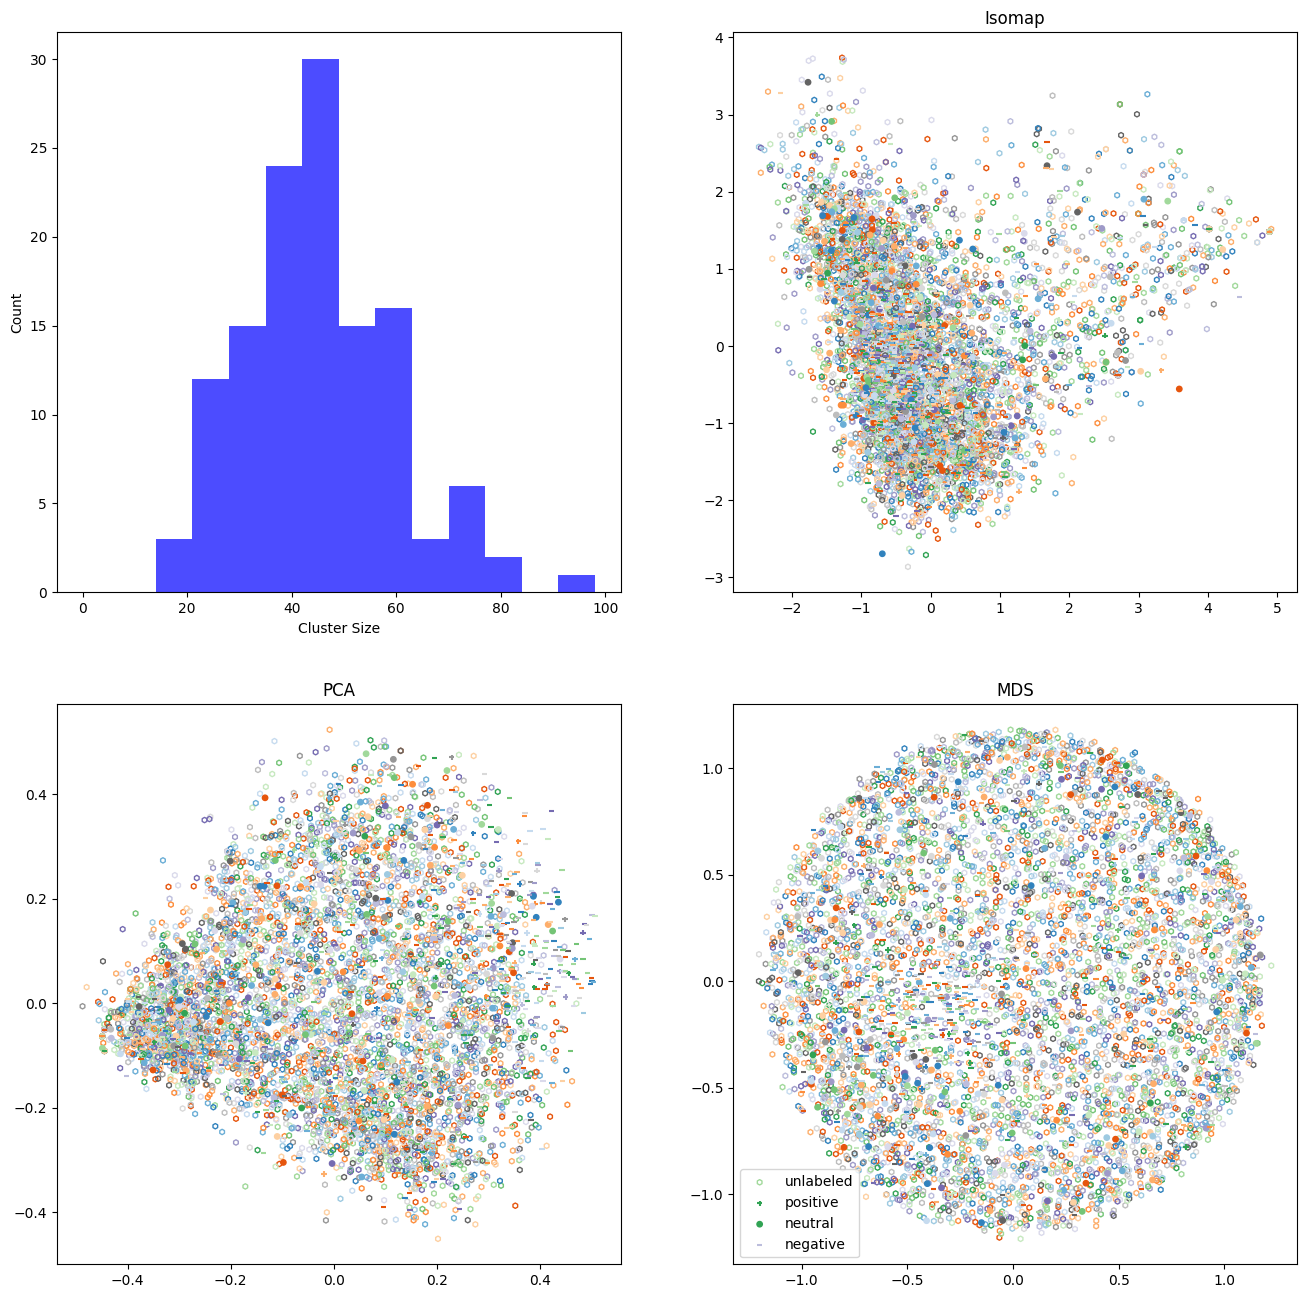

In [453]:
reduction_names = ['Isomap', 'PCA', 'MDS']
cluster_id = df_all.sort_values('chunk_id').cluster
marker_size = 15

fig = plt.figure(figsize=(16,16))

cluster_sizes = cluster_id.reset_index().groupby('cluster').count()
ax = fig.add_subplot(2, 2, 1)
# Make a histogram of cluster sizes
plt.hist(cluster_sizes.values, bins=list(np.linspace(0, cluster_sizes.max().values+1, 15).T[0]), color='b', alpha=0.7)
# Add a vertical line at 0
ax.set_xlabel('Cluster Size')
ax.set_ylabel('Count')

for subplot_id, reduction_name in enumerate(reduction_names):
    reduced_vectors = reduced_embeddings[reduction_name]

    index_dict = { 
        'unlabeled' : df_all[df_all.label.isna()].chunk_id.values,
        'positive' : df_all[df_all.label==1].chunk_id.values,
        'neutral' : df_all[df_all.label==0].chunk_id.values,
        'negative' : df_all[df_all.label==-1].chunk_id.values
    }
    markers = ["h",'+', 'o', '_']

    ax = fig.add_subplot(2, 2, subplot_id+2)

    for i, (index_name, indexes) in enumerate(index_dict.items()):
        if i==0:
            im = ax.scatter(reduced_vectors[indexes, 0], reduced_vectors[indexes, 1],  edgecolors = plt.cm.tab20c(cluster_id[indexes]%20), facecolors='none', label=index_name, marker=markers[i], s=marker_size)
            continue
        im = ax.scatter(reduced_vectors[indexes, 0], reduced_vectors[indexes, 1], c=cluster_id[indexes], cmap='tab20c', label=index_name, marker=markers[i], s=marker_size)
    ax.set_title(f'{reduction_name}')
plt.legend()
plt.show()

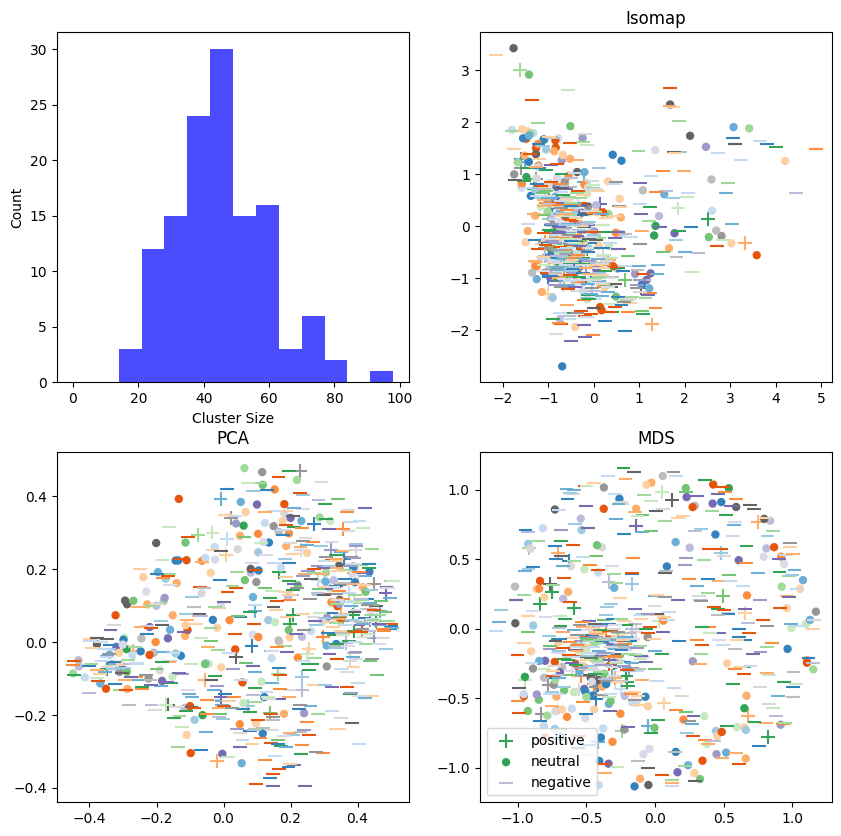

In [454]:
reduction_names = ['Isomap', 'PCA', 'MDS']
cluster_id = df_all.sort_values('chunk_id').cluster

fig = plt.figure(figsize=(10,10))

cluster_sizes = cluster_id.reset_index().groupby('cluster').count()
ax = fig.add_subplot(2, 2, 1)
# Make a histogram of cluster sizes
plt.hist(cluster_sizes.values, bins=list(np.linspace(0, cluster_sizes.max().values+1, 15).T[0]), color='b', alpha=0.7)
# Add a vertical line at 0
ax.set_xlabel('Cluster Size')
ax.set_ylabel('Count')

for subplot_id, reduction_name in enumerate(reduction_names):
    reduced_vectors = reduced_embeddings[reduction_name]

    index_dict = { 
        'positive' : df_all[df_all.label==1].chunk_id.values,
        'neutral' : df_all[df_all.label==0].chunk_id.values,
        'negative' : df_all[df_all.label==-1].chunk_id.values
    }
    markers = ['+', '.', '_']

    ax = fig.add_subplot(2, 2, subplot_id+2)

    for i, (index_name, indexes) in enumerate(index_dict.items()):
        im = ax.scatter(reduced_vectors[indexes, 0], reduced_vectors[indexes, 1], c=cluster_id[indexes], cmap='tab20c', label=index_name, marker=markers[i], s=100)
    ax.set_title(f'{reduction_name}')
plt.legend()
plt.show()

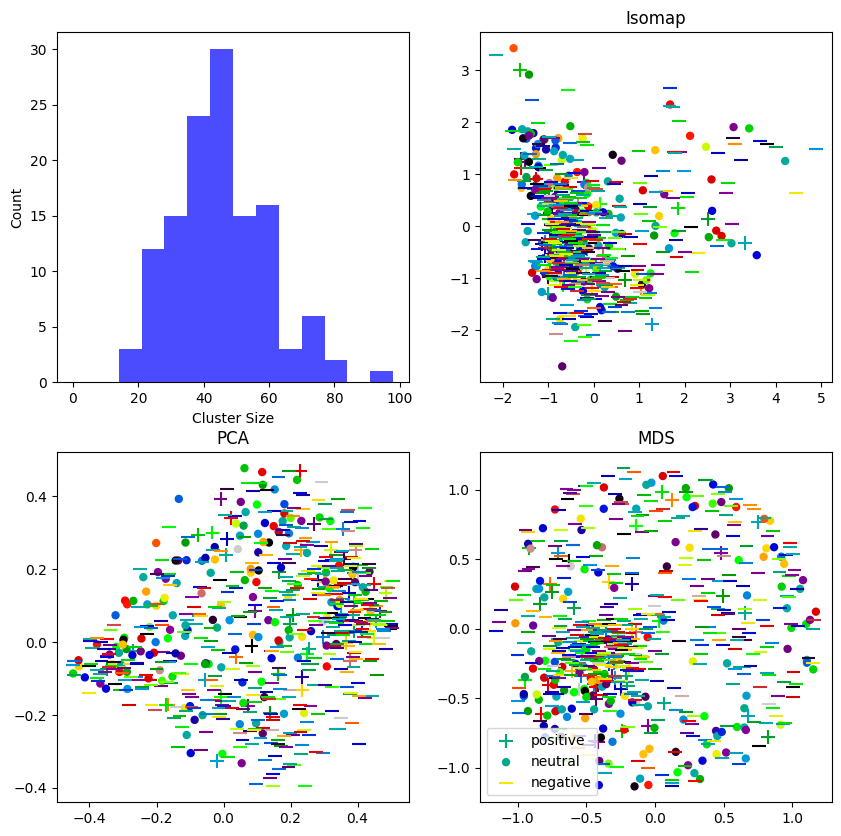

In [455]:
reduction_names = ['Isomap', 'PCA', 'MDS']
cluster_id = df_all.sort_values('chunk_id').cluster

fig = plt.figure(figsize=(10,10))

cluster_sizes = cluster_id.reset_index().groupby('cluster').count()
ax = fig.add_subplot(2, 2, 1)
# Make a histogram of cluster sizes
plt.hist(cluster_sizes.values, bins=list(np.linspace(0, cluster_sizes.max().values+1, 15).T[0]), color='b', alpha=0.7)
# Add a vertical line at 0
ax.set_xlabel('Cluster Size')
ax.set_ylabel('Count')

for subplot_id, reduction_name in enumerate(reduction_names):
    reduced_vectors = reduced_embeddings[reduction_name]

    index_dict = { 
        'positive' : df_all[df_all.label==1].chunk_id.values,
        'neutral' : df_all[df_all.label==0].chunk_id.values,
        'negative' : df_all[df_all.label==-1].chunk_id.values
    }
    markers = ['+', '.', '_']

    ax = fig.add_subplot(2, 2, subplot_id+2)

    for i, (index_name, indexes) in enumerate(index_dict.items()):
        im = ax.scatter(reduced_vectors[indexes, 0], reduced_vectors[indexes, 1], c=cluster_id[indexes], cmap='nipy_spectral', label=index_name, marker=markers[i], s=100)
    ax.set_title(f'{reduction_name}')
plt.legend()
plt.show()